In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [3]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os,math,pickle
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate,cross_val_predict,StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,roc_auc_score
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [4]:
path = 'data/'

In [5]:
# hyper-parameters of the utility kernel
c = 100
K_0 = 0.1
K_1 = 10
Alpha = 5

# number of PCA features by fixing the variance of 95%
NumComponents = 0.95

# number of samples of minority classes at various survival cut-offs
long_data_num_5yr = 204
long_data_num_6yr = 584
long_data_num_7yr = 187
long_data_num_8yr = 127
long_data_num_9yr = 102

In [6]:
# various survival cut-offs csv files
survival_file_name_5yr = 'class_5_year.csv'
survival_file_name_6yr = 'class_6_year.csv'
survival_file_name_7yr = 'class_7_year.csv'
survival_file_name_8yr = 'class_8_year.csv'
survival_file_name_9yr = 'class_9_year.csv'

In [7]:
#change for each survival year cutoff
long_data_num = long_data_num_7yr
survival_file_name = survival_file_name_7yr

In [8]:
def data_sampler(long_data,short_data):
	#subsampling the long data
	df = pd.DataFrame(long_data)
	long_data=df.sample(n = long_data_num)

	#generating balanced class data for training
	data = np.vstack((long_data,short_data))
	#print(data.shape)
	return data

In [9]:
#define utility kernel
def utility_kernel(X, Y):
    k_0 =K_0
    k_1 = K_1
    alpha = Alpha
    kernel_value = k_0+np.multiply(k_1,np.power((np.dot(X, Y.T)),alpha))
    return kernel_value

In [10]:
def my_pca(data,numComponents):
	#Applying PCA with 95% explained_variance_ratio_
	plt.style.use('ggplot')
	pca = PCA(n_components=numComponents, random_state=42)
	pca.fit(data) 
	data = pca.transform(data)
	plt.plot(np.cumsum(pca.explained_variance_ratio_))
	plt.xlabel('number of components')
	plt.ylabel('Explained variance')
	plt.savefig(os.path.join(path,'elbow_plot_multimodal.png'),dpi=100)
	return data

In [11]:
def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom

In [12]:
CLN = np.loadtxt(os.path.join(path,'tcga_cln_final.csv'), delimiter=",")
WSI = np.loadtxt(os.path.join(path,'tcga_allWSIpatchfused.csv'), delimiter=",")
EXP = np.loadtxt(os.path.join(path,'tcga_exp_final.csv'), delimiter=",")
CNV = np.loadtxt(os.path.join(path,'tcga_cnv_final.csv'), delimiter=",")
CLN_EXP    = np.concatenate((CLN,EXP),axis=1)
CLN_CNV    = np.concatenate((CLN,CNV),axis=1)
CLN_WSI    = np.concatenate((CLN,WSI),axis=1)
EXP_CNV    = np.concatenate((EXP,CNV),axis=1)
EXP_WSI    = np.concatenate((EXP,WSI),axis=1)
CNV_WSI    = np.concatenate((CNV,WSI),axis=1)
CLN_EXP_CNV     = np.concatenate((CLN,EXP,CNV),axis=1)
CLN_EXP_WSI     = np.concatenate((CLN,EXP,WSI),axis=1)
EXP_CNV_WSI     = np.concatenate((EXP,CNV,WSI),axis=1)
CNV_CLN_WSI     = np.concatenate((CNV,CLN,WSI),axis=1)
multimodal     = np.concatenate((WSI,CLN,CNV,EXP),axis=1)
y_multimodal 	  = np.loadtxt(os.path.join(path, survival_file_name))

In [13]:
y_multimodal

array([1., 1., 1., ..., 1., 1., 1.])

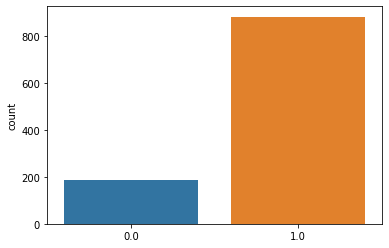

In [14]:
import seaborn as sns
sns.countplot(x=y_multimodal)

In [15]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score, accuracy_score, precision_score, recall_score, f1_score,jaccard_score,fbeta_score 

In [16]:
ML_Model = []
accuracy = []
roc = []
precision = []
recall = []
f1score = []
mcc = []
kappa = []
jacc = []
gmea = []

#function to call for storing the results
def storeResults(model, a,b,c,d,e,f,g,h,i):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    roc.append(round(b, 3))
    precision.append(round(c, 3))
    recall.append(round(d, 3))
    f1score.append(round(e,3))
    mcc.append(round(f,3))
    kappa.append(round(g,3))
    jacc.append(round(h,3))
    gmea.append(round(i,3))


# CLN

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(CLN, y_multimodal, test_size = 0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((907, 10), (907,), (161, 10), (161,))

# SVM - RBF

In [18]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm_acc_a = accuracy_score(y_pred, y_test)
svm_roc_a = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm_prec_a = precision_score(y_pred, y_test)
svm_rec_a = recall_score(y_pred, y_test)
svm_f1_a = f1_score(y_pred, y_test)
svm_mcc_a = matthews_corrcoef(y_pred, y_test)
svm_kap_a = cohen_kappa_score(y_pred, y_test)
svm_jacc_a = jaccard_score(y_pred, y_test)
svm_gmea_a = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN - SVM - rbf',svm_acc_a,svm_roc_a,svm_prec_a,svm_rec_a,svm_f1_a,svm_mcc_a,svm_kap_a,svm_jacc_a,svm_gmea_a)

# SVM - Poly

In [19]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm1_acc_a = accuracy_score(y_pred, y_test)
svm1_roc_a = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm1_prec_a = precision_score(y_pred, y_test)
svm1_rec_a = recall_score(y_pred, y_test)
svm1_f1_a = f1_score(y_pred, y_test)
svm1_mcc_a = matthews_corrcoef(y_pred, y_test)
svm1_kap_a = cohen_kappa_score(y_pred, y_test)
svm1_jacc_a = jaccard_score(y_pred, y_test)
svm1_gmea_a = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN - SVM - Poly',svm1_acc_a,svm1_roc_a,svm1_prec_a,svm1_rec_a,svm1_f1_a,svm1_mcc_a,svm1_kap_a,svm1_jacc_a,svm1_gmea_a)

# SVM - Utility Kerenl

In [20]:
clf = SVC(C=c,kernel=utility_kernel, probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm2_acc_a = accuracy_score(y_pred, y_test)
svm2_roc_a = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm2_prec_a = precision_score(y_pred, y_test)
svm2_rec_a = recall_score(y_pred, y_test)
svm2_f1_a = f1_score(y_pred, y_test)
svm2_mcc_a = matthews_corrcoef(y_pred, y_test)
svm2_kap_a = cohen_kappa_score(y_pred, y_test)
svm2_jacc_a = jaccard_score(y_pred, y_test)
svm2_gmea_a = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN - SVM - Utility ',svm2_acc_a,svm2_roc_a,svm2_prec_a,svm2_rec_a,svm2_f1_a,svm2_mcc_a,svm2_kap_a,svm2_jacc_a,svm2_gmea_a)

# SVC - Linear

In [21]:
clf = SVC(kernel ='linear',probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm3_acc_a = accuracy_score(y_pred, y_test)
svm3_roc_a = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm3_prec_a = precision_score(y_pred, y_test)
svm3_rec_a = recall_score(y_pred, y_test)
svm3_f1_a = f1_score(y_pred, y_test)
svm3_mcc_a = matthews_corrcoef(y_pred, y_test)
svm3_kap_a = cohen_kappa_score(y_pred, y_test)
svm3_jacc_a = jaccard_score(y_pred, y_test)
svm3_gmea_a = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN - SVM - Linear ',svm3_acc_a,svm3_roc_a,svm3_prec_a,svm3_rec_a,svm3_f1_a,svm3_mcc_a,svm3_kap_a,svm3_jacc_a,svm3_gmea_a)

# SVC - Sigmoid

In [22]:
clf = SVC(kernel ='sigmoid', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm4_acc_a = accuracy_score(y_pred, y_test)
svm4_roc_a = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm4_prec_a = precision_score(y_pred, y_test)
svm4_rec_a = recall_score(y_pred, y_test)
svm4_f1_a = f1_score(y_pred, y_test)
svm4_mcc_a = matthews_corrcoef(y_pred, y_test)
svm4_kap_a = cohen_kappa_score(y_pred, y_test)
svm4_jacc_a = jaccard_score(y_pred, y_test)
svm4_gmea_a = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN - SVM - Sigmoid',svm4_acc_a,svm4_roc_a,svm4_prec_a,svm4_rec_a,svm4_f1_a,svm4_mcc_a,svm4_kap_a,svm4_jacc_a,svm4_gmea_a)

# Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model 
rf = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

rf_acc_a = accuracy_score(y_pred, y_test)
rf_roc_a = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
rf_prec_a = precision_score(y_pred, y_test)
rf_rec_a = recall_score(y_pred, y_test)
rf_f1_a = f1_score(y_pred, y_test)
rf_mcc_a = matthews_corrcoef(y_pred, y_test)
rf_kap_a = cohen_kappa_score(y_pred, y_test)
rf_jacc_a = jaccard_score(y_pred, y_test)
rf_gmea_a = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN - RF',rf_acc_a,rf_roc_a,rf_prec_a,rf_rec_a,rf_f1_a,rf_mcc_a,rf_kap_a,rf_jacc_a,rf_gmea_a)

# Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)

dt_acc_a = accuracy_score(y_pred, y_test)
dt_roc_a = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
dt_prec_a = precision_score(y_pred, y_test)
dt_rec_a = recall_score(y_pred, y_test)
dt_f1_a = f1_score(y_pred, y_test)
dt_mcc_a = matthews_corrcoef(y_pred, y_test)
dt_kap_a = cohen_kappa_score(y_pred, y_test)
dt_jacc_a = jaccard_score(y_pred, y_test)
dt_gmea_a = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN - DT',dt_acc_a,dt_roc_a,dt_prec_a,dt_rec_a,dt_f1_a,dt_mcc_a,dt_kap_a,dt_jacc_a,dt_gmea_a)

# Naive Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.pipeline import Pipeline

# instantiate the model
nb=  GaussianNB()

# fit the model 
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
y_prob = nb.predict_proba(X_test)

nb_acc_a = accuracy_score(y_pred, y_test)
nb_roc_a = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
nb_prec_a = precision_score(y_pred, y_test)
nb_rec_a = recall_score(y_pred, y_test)
nb_f1_a = f1_score(y_pred, y_test)
nb_mcc_a = matthews_corrcoef(y_pred, y_test)
nb_kap_a = cohen_kappa_score(y_pred, y_test)
nb_jacc_a = jaccard_score(y_pred, y_test)
nb_gmea_a = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN - NB',nb_acc_a,nb_roc_a,nb_prec_a,nb_rec_a,nb_f1_a,nb_mcc_a,nb_kap_a,nb_jacc_a,nb_gmea_a)

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2 = SVC(probability=True)
clf3 = DecisionTreeClassifier(max_depth=30)

eclf1 = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train, y_train)

y_pred = eclf1.predict(X_test)
y_prob = eclf1.predict_proba(X_test)

vot_acc_a = accuracy_score(y_pred, y_test)
vot_roc_a = roc_auc_score(y_test, eclf1.predict_proba(X_test)[:, 1])
vot_prec_a = precision_score(y_pred, y_test)
vot_rec_a = recall_score(y_pred, y_test)
vot_f1_a = f1_score(y_pred, y_test)
vot_mcc_a = matthews_corrcoef(y_pred, y_test)
vot_kap_a = cohen_kappa_score(y_pred, y_test)
vot_jacc_a = jaccard_score(y_pred, y_test)
vot_gmea_a = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN - vot',vot_acc_a,vot_roc_a,vot_prec_a,vot_rec_a,vot_f1_a,vot_mcc_a,vot_kap_a,vot_jacc_a,vot_gmea_a)

# DL

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

X_train=X_train
X_test=X_test

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

# VGGNets

In [28]:
verbose, epoch, batch_size = 1, 100, 4
activationFunction='relu'

def VGGNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = VGGNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 9, 128)            384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 1,410
Trainable params: 1,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 3s 179ms/step - loss: 0.6964 - accuracy: 0.3750 - val_loss: 0.6630 - v

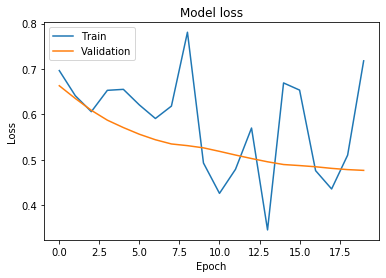

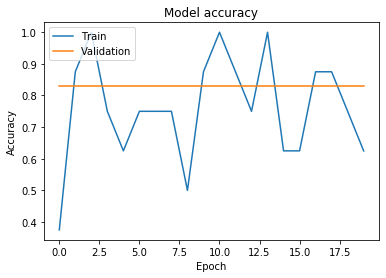

In [29]:
# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

In [30]:
cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

vgg_acc_a = accuracy_score(y_pred, y_test)
vgg_roc_a = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
vgg_prec_a = precision_score(y_pred, y_test)
vgg_rec_a = recall_score(y_pred, y_test)
vgg_f1_a = f1_score(y_pred, y_test)
vgg_mcc_a = matthews_corrcoef(y_pred, y_test)
vgg_kap_a = cohen_kappa_score(y_pred, y_test)
vgg_jacc_a = jaccard_score(y_pred, y_test)
vgg_gmea_a = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN - VGGNets',vgg_acc_a,vgg_roc_a,vgg_prec_a,vgg_rec_a,vgg_f1_a,vgg_mcc_a,vgg_kap_a,vgg_jacc_a,vgg_gmea_a)

6/6 [==============================] - 0s 1ms/step


# ResNets

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 9, 128)            384       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 1,410
Trainable params: 1,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 152ms/step - loss: 0.7165 - accuracy: 0.1250 - val_loss: 0.6858 -

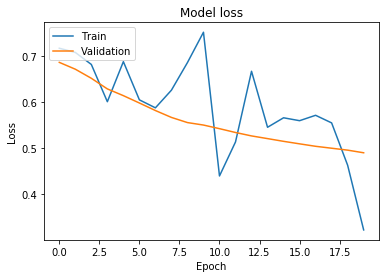

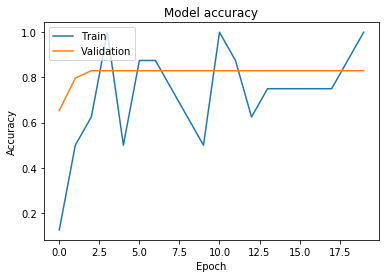

6/6 [==============================] - 0s 1ms/step


In [31]:
def ResNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = ResNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

res_acc_a = accuracy_score(y_pred, y_test)
res_roc_a = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
res_prec_a = precision_score(y_pred, y_test)
res_rec_a = recall_score(y_pred, y_test)
res_f1_a = f1_score(y_pred, y_test)
res_mcc_a = matthews_corrcoef(y_pred, y_test)
res_kap_a = cohen_kappa_score(y_pred, y_test)
res_jacc_a = jaccard_score(y_pred, y_test)
res_gmea_a = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN - ResNets',res_acc_a,res_roc_a,res_prec_a,res_rec_a,res_f1_a,res_mcc_a,res_kap_a,res_jacc_a,res_gmea_a)

# DesNet

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 9, 128)            384       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 128)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 1,410
Trainable params: 1,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 150ms/step - loss: 0.6863 - accuracy: 0.7500 - val_loss: 0.6516 -

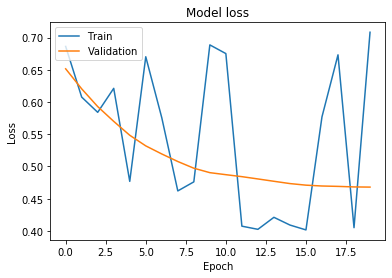

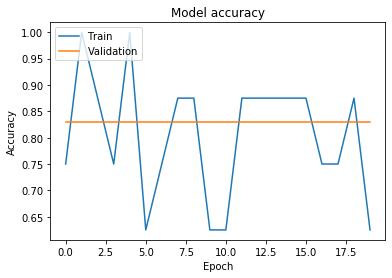

6/6 [==============================] - 0s 2ms/step


In [32]:
def DenseNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = DenseNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

dense_acc_a = accuracy_score(y_pred, y_test)
dense_roc_a = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
dense_prec_a = precision_score(y_pred, y_test)
dense_rec_a = recall_score(y_pred, y_test)
dense_f1_a = f1_score(y_pred, y_test)
dense_mcc_a = matthews_corrcoef(y_pred, y_test)
dense_kap_a = cohen_kappa_score(y_pred, y_test)
dense_jacc_a = jaccard_score(y_pred, y_test)
dense_gmea_a = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN - DenseNets',dense_acc_a,dense_roc_a,dense_prec_a,dense_rec_a,dense_f1_a,dense_mcc_a,dense_kap_a,dense_jacc_a,dense_gmea_a)

# WSI

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(WSI, y_multimodal, test_size = 0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((907, 800), (907,), (161, 800), (161,))

In [34]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm_acc_b = accuracy_score(y_pred, y_test)
svm_roc_b = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm_prec_b = precision_score(y_pred, y_test)
svm_rec_b = recall_score(y_pred, y_test)
svm_f1_b = f1_score(y_pred, y_test)
svm_mcc_b = matthews_corrcoef(y_pred, y_test)
svm_kap_b = cohen_kappa_score(y_pred, y_test)
svm_jacc_b = jaccard_score(y_pred, y_test)
svm_gmea_b = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('WSI - SVM - rbf',svm_acc_b,svm_roc_b,svm_prec_b,svm_rec_b,svm_f1_b,svm_mcc_b,svm_kap_b,svm_jacc_b,svm_gmea_b)

In [35]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm1_acc_b = accuracy_score(y_pred, y_test)
svm1_roc_b = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm1_prec_b = precision_score(y_pred, y_test)
svm1_rec_b = recall_score(y_pred, y_test)
svm1_f1_b = f1_score(y_pred, y_test)
svm1_mcc_b = matthews_corrcoef(y_pred, y_test)
svm1_kap_b = cohen_kappa_score(y_pred, y_test)
svm1_jacc_b = jaccard_score(y_pred, y_test)
svm1_gmea_b = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('WSI - SVM - Poly',svm1_acc_b,svm1_roc_b,svm1_prec_b,svm1_rec_b,svm1_f1_b,svm1_mcc_b,svm1_kap_b,svm1_jacc_b,svm1_gmea_a)

In [36]:
clf = SVC(C=c,kernel=utility_kernel, probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm2_acc_b = accuracy_score(y_pred, y_test)
svm2_roc_b = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm2_prec_b = precision_score(y_pred, y_test)
svm2_rec_b = recall_score(y_pred, y_test)
svm2_f1_b = f1_score(y_pred, y_test)
svm2_mcc_b = matthews_corrcoef(y_pred, y_test)
svm2_kap_b = cohen_kappa_score(y_pred, y_test)
svm2_jacc_b = jaccard_score(y_pred, y_test)
svm2_gmea_b = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('WSI - SVM - Utility ',svm2_acc_b,svm2_roc_b,svm2_prec_b,svm2_rec_b,svm2_f1_b,svm2_mcc_b,svm2_kap_b,svm2_jacc_b,svm2_gmea_b)

In [37]:
clf = SVC(kernel ='linear', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm3_acc_b =accuracy_score(y_pred, y_test)
svm3_roc_b = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm3_prec_b =precision_score(y_pred, y_test)
svm3_rec_b =recall_score(y_pred, y_test)
svm3_f1_b =f1_score(y_pred, y_test)
svm3_mcc_b =matthews_corrcoef(y_pred, y_test)
svm3_kap_b =cohen_kappa_score(y_pred, y_test)
svm3_jacc_b =jaccard_score(y_pred, y_test)
svm3_gmea_b =fbeta_score(y_pred, y_test, beta=0.5)

storeResults('WSI - SVM - Linear ',svm3_acc_b,svm3_roc_b,svm3_prec_b,svm3_rec_b,svm3_f1_b,svm3_mcc_b,svm3_kap_b,svm3_jacc_b,svm3_gmea_b)

In [38]:
clf = SVC(kernel ='sigmoid', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm4_acc_b = accuracy_score(y_pred, y_test)
svm4_roc_b = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm4_prec_b = precision_score(y_pred, y_test)
svm4_rec_b = recall_score(y_pred, y_test)
svm4_f1_b = f1_score(y_pred, y_test)
svm4_mcc_b = matthews_corrcoef(y_pred, y_test)
svm4_kap_b = cohen_kappa_score(y_pred, y_test)
svm4_jacc_b = jaccard_score(y_pred, y_test)
svm4_gmea_b = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('WSI - SVM - Sigmoid',svm4_acc_b,svm4_roc_b,svm4_prec_b,svm4_rec_b,svm4_f1_b,svm4_mcc_b,svm4_kap_b,svm4_jacc_b,svm4_gmea_b)

In [39]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model 
rf = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

rf_acc_b = accuracy_score(y_pred, y_test)
rf_roc_b = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
rf_prec_b = precision_score(y_pred, y_test)
rf_rec_b = recall_score(y_pred, y_test)
rf_f1_b = f1_score(y_pred, y_test)
rf_mcc_b = matthews_corrcoef(y_pred, y_test)
rf_kap_b = cohen_kappa_score(y_pred, y_test)
rf_jacc_b = jaccard_score(y_pred, y_test)
rf_gmea_b = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('WSI - RF',rf_acc_b,rf_roc_b,rf_prec_b,rf_rec_b,rf_f1_b,rf_mcc_b,rf_kap_b,rf_jacc_b,rf_gmea_b)

In [40]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)

dt_acc_b = accuracy_score(y_pred, y_test)
dt_roc_b = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
dt_prec_b = precision_score(y_pred, y_test)
dt_rec_b = recall_score(y_pred, y_test)
dt_f1_b = f1_score(y_pred, y_test)
dt_mcc_b = matthews_corrcoef(y_pred, y_test)
dt_kap_b = cohen_kappa_score(y_pred, y_test)
dt_jacc_b = jaccard_score(y_pred, y_test)
dt_gmea_b = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('WSI - DT',dt_acc_b,dt_roc_b,dt_prec_b,dt_rec_b,dt_f1_b,dt_mcc_b,dt_kap_b,dt_jacc_b,dt_gmea_b)

In [41]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.pipeline import Pipeline

# instantiate the model
nb=  GaussianNB()

# fit the model 
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
y_prob = nb.predict_proba(X_test)

nb_acc_b = accuracy_score(y_pred, y_test)
nb_roc_b = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
nb_prec_b = precision_score(y_pred, y_test)
nb_rec_b = recall_score(y_pred, y_test)
nb_f1_b = f1_score(y_pred, y_test)
nb_mcc_b = matthews_corrcoef(y_pred, y_test)
nb_kap_b = cohen_kappa_score(y_pred, y_test)
nb_jacc_b = jaccard_score(y_pred, y_test)
nb_gmea_b = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('WSI - NB',nb_acc_b,nb_roc_b,nb_prec_b,nb_rec_b,nb_f1_b,nb_mcc_b,nb_kap_b,nb_jacc_b,nb_gmea_b)

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2 = SVC(probability=True)
clf3 = DecisionTreeClassifier(max_depth=30)

eclf1 = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train, y_train)

y_pred = eclf1.predict(X_test)
y_prob = eclf1.predict_proba(X_test)

vot_acc_b = accuracy_score(y_pred, y_test)
vot_roc_b = roc_auc_score(y_test, eclf1.predict_proba(X_test)[:, 1])
vot_prec_b = precision_score(y_pred, y_test)
vot_rec_b = recall_score(y_pred, y_test)
vot_f1_b = f1_score(y_pred, y_test)
vot_mcc_b = matthews_corrcoef(y_pred, y_test)
vot_kap_b = cohen_kappa_score(y_pred, y_test)
vot_jacc_b = jaccard_score(y_pred, y_test)
vot_gmea_b = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('WSI- vot',vot_acc_b,vot_roc_b,vot_prec_b,vot_rec_b,vot_f1_b,vot_mcc_b,vot_kap_b,vot_jacc_b,vot_gmea_b)

# DL

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

X_train=X_train
X_test=X_test

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 799, 128)          384       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 399, 128)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 399, 128)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 51072)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102146    
Total params: 102,530
Trainable params: 102,530
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 262ms/step - loss: 0.6338 - accuracy: 0.6250 - val_loss: 16.1

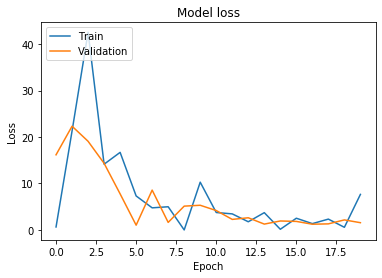

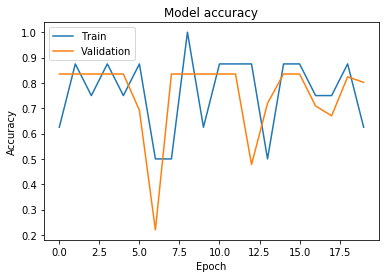

6/6 [==============================] - 0s 3ms/step


In [44]:
verbose, epoch, batch_size = 1, 100, 4
activationFunction='relu'

def VGGNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = VGGNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)


# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

vgg_acc_b = accuracy_score(y_pred, y_test)
vgg_roc_b = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
vgg_prec_b = precision_score(y_pred, y_test)
vgg_rec_b = recall_score(y_pred, y_test)
vgg_f1_b = f1_score(y_pred, y_test)
vgg_mcc_b = matthews_corrcoef(y_pred, y_test)
vgg_kap_b = cohen_kappa_score(y_pred, y_test)
vgg_jacc_b = jaccard_score(y_pred, y_test)
vgg_gmea_b = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('WSI - VGGNets',vgg_acc_b,vgg_roc_b,vgg_prec_b,vgg_rec_b,vgg_f1_b,vgg_mcc_b,vgg_kap_b,vgg_jacc_b,vgg_gmea_b)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 799, 128)          384       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 399, 128)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 399, 128)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 51072)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102146    
Total params: 102,530
Trainable params: 102,530
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 151ms/step - loss: 19.8071 - accuracy: 0.5000 - val_loss: 7.3

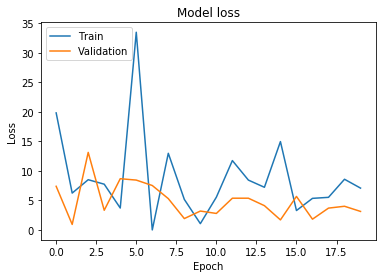

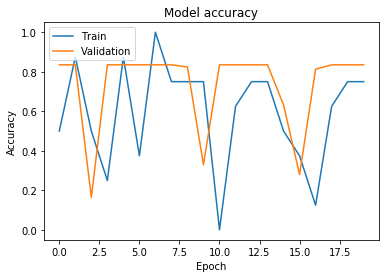

6/6 [==============================] - 0s 950us/step


In [45]:
def ResNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = ResNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

res_acc_b = accuracy_score(y_pred, y_test)
res_roc_b = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
res_prec_b = precision_score(y_pred, y_test)
res_rec_b = recall_score(y_pred, y_test)
res_f1_b = f1_score(y_pred, y_test)
res_mcc_b = matthews_corrcoef(y_pred, y_test)
res_kap_b = cohen_kappa_score(y_pred, y_test)
res_jacc_b = jaccard_score(y_pred, y_test)
res_gmea_b = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('WSI - ResNets',res_acc_b,res_roc_b,res_prec_b,res_rec_b,res_f1_b,res_mcc_b,res_kap_b,res_jacc_b,res_gmea_b)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 799, 128)          384       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 399, 128)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 399, 128)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 51072)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 102146    
Total params: 102,530
Trainable params: 102,530
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 156ms/step - loss: 2.2428 - accuracy: 0.6250 - val_loss: 2.16

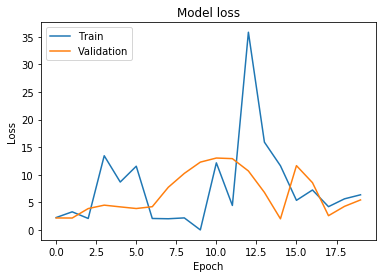

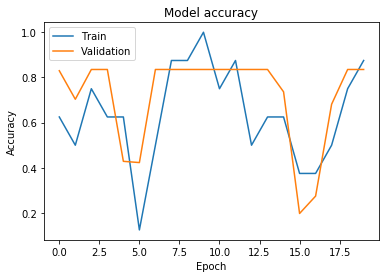

6/6 [==============================] - 0s 1ms/step


In [46]:
def DenseNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = DenseNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

dense_acc_b = accuracy_score(y_pred, y_test)
dense_roc_b = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
dense_prec_b = precision_score(y_pred, y_test)
dense_rec_b = recall_score(y_pred, y_test)
dense_f1_b = f1_score(y_pred, y_test)
dense_mcc_b = matthews_corrcoef(y_pred, y_test)
dense_kap_b = cohen_kappa_score(y_pred, y_test)
dense_jacc_b = jaccard_score(y_pred, y_test)
dense_gmea_b = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('WSI - DenseNets',dense_acc_b,dense_roc_b,dense_prec_b,dense_rec_b,dense_f1_b,dense_mcc_b,dense_kap_b,dense_jacc_b,dense_gmea_b)

# EXP

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(EXP, y_multimodal, test_size = 0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((907, 400), (907,), (161, 400), (161,))

In [48]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm_acc_c = accuracy_score(y_pred, y_test)
svm_roc_c = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm_prec_c = precision_score(y_pred, y_test)
svm_rec_c = recall_score(y_pred, y_test)
svm_f1_c = f1_score(y_pred, y_test)
svm_mcc_c = matthews_corrcoef(y_pred, y_test)
svm_kap_c = cohen_kappa_score(y_pred, y_test)
svm_jacc_c = jaccard_score(y_pred, y_test)
svm_gmea_c = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP - SVM - rbf',svm_acc_c,svm_roc_c,svm_prec_c,svm_rec_c,svm_f1_c,svm_mcc_c,svm_kap_c,svm_jacc_c,svm_gmea_c)

In [49]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm1_acc_c = accuracy_score(y_pred, y_test)
svm1_roc_c = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm1_prec_c = precision_score(y_pred, y_test)
svm1_rec_c = recall_score(y_pred, y_test)
svm1_f1_c = f1_score(y_pred, y_test)
svm1_mcc_c = matthews_corrcoef(y_pred, y_test)
svm1_kap_c = cohen_kappa_score(y_pred, y_test)
svm1_jacc_c = jaccard_score(y_pred, y_test)
svm1_gmea_c = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP - SVM - Poly',svm1_acc_c,svm1_roc_c,svm1_prec_c,svm1_rec_c,svm1_f1_c,svm1_mcc_c,svm1_kap_c,svm1_jacc_c,svm1_gmea_c)

In [50]:
clf = SVC(C=c,kernel=utility_kernel, probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm2_acc_c = accuracy_score(y_pred, y_test)
svm2_roc_c = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm2_prec_c = precision_score(y_pred, y_test)
svm2_rec_c = recall_score(y_pred, y_test)
svm2_f1_c = f1_score(y_pred, y_test)
svm2_mcc_c = matthews_corrcoef(y_pred, y_test)
svm2_kap_c = cohen_kappa_score(y_pred, y_test)
svm2_jacc_c = jaccard_score(y_pred, y_test)
svm2_gmea_c = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP - SVM - Utility ',svm2_acc_c,svm2_roc_c,svm2_prec_c,svm2_rec_c,svm2_f1_c,svm2_mcc_c,svm2_kap_c,svm2_jacc_c,svm2_gmea_c)

In [51]:
clf = SVC(kernel ='linear', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm3_acc_c = accuracy_score(y_pred, y_test)
svm3_roc_c = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm3_prec_c = precision_score(y_pred, y_test)
svm3_rec_c = recall_score(y_pred, y_test)
svm3_f1_c = f1_score(y_pred, y_test)
svm3_mcc_c = matthews_corrcoef(y_pred, y_test)
svm3_kap_c = cohen_kappa_score(y_pred, y_test)
svm3_jacc_c = jaccard_score(y_pred, y_test)
svm3_gmea_c = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP - SVM - Linear ',svm3_acc_c,svm3_roc_c,svm3_prec_c,svm3_rec_c,svm3_f1_c,svm3_mcc_c,svm3_kap_c,svm3_jacc_c,svm3_gmea_c)

In [52]:
clf = SVC(kernel ='sigmoid', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm4_acc_c = accuracy_score(y_pred, y_test)
svm4_roc_c = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm4_prec_c = precision_score(y_pred, y_test)
svm4_rec_c = recall_score(y_pred, y_test)
svm4_f1_c = f1_score(y_pred, y_test)
svm4_mcc_c = matthews_corrcoef(y_pred, y_test)
svm4_kap_c = cohen_kappa_score(y_pred, y_test)
svm4_jacc_c = jaccard_score(y_pred, y_test)
svm4_gmea_c = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP - SVM - Sigmoid',svm4_acc_c,svm4_roc_c,svm4_prec_c,svm4_rec_c,svm4_f1_c,svm4_mcc_c,svm4_kap_c,svm4_jacc_c,svm4_gmea_c)

In [53]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model 
rf = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

rf_acc_c = accuracy_score(y_pred, y_test)
rf_roc_c = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
rf_prec_c = precision_score(y_pred, y_test)
rf_rec_c = recall_score(y_pred, y_test)
rf_f1_c = f1_score(y_pred, y_test)
rf_mcc_c = matthews_corrcoef(y_pred, y_test)
rf_kap_c = cohen_kappa_score(y_pred, y_test)
rf_jacc_c = jaccard_score(y_pred, y_test)
rf_gmea_c = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP - RF',rf_acc_c,rf_roc_c,rf_prec_c,rf_rec_c,rf_f1_c,rf_mcc_c,rf_kap_c,rf_jacc_c,rf_gmea_c)

In [54]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)

dt_acc_c = accuracy_score(y_pred, y_test)
dt_roc_c = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
dt_prec_c = precision_score(y_pred, y_test)
dt_rec_c = recall_score(y_pred, y_test)
dt_f1_c = f1_score(y_pred, y_test)
dt_mcc_c = matthews_corrcoef(y_pred, y_test)
dt_kap_c = cohen_kappa_score(y_pred, y_test)
dt_jacc_c = jaccard_score(y_pred, y_test)
dt_gmea_c = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP - DT',dt_acc_c,dt_roc_c,dt_prec_c,dt_rec_c,dt_f1_c,dt_mcc_c,dt_kap_c,dt_jacc_c,dt_gmea_c)

In [55]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.pipeline import Pipeline

# instantiate the model
nb=  GaussianNB()

# fit the model 
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
y_prob = nb.predict_proba(X_test)

nb_acc_c = accuracy_score(y_pred, y_test)
nb_roc_c = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
nb_prec_c = precision_score(y_pred, y_test)
nb_rec_c = recall_score(y_pred, y_test)
nb_f1_c = f1_score(y_pred, y_test)
nb_mcc_c = matthews_corrcoef(y_pred, y_test)
nb_kap_c = cohen_kappa_score(y_pred, y_test)
nb_jacc_c = jaccard_score(y_pred, y_test)
nb_gmea_c = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP - NB',nb_acc_c,nb_roc_c,nb_prec_c,nb_rec_c,nb_f1_c,nb_mcc_c,nb_kap_c,nb_jacc_c,nb_gmea_c)

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2 = SVC(probability=True)
clf3 = DecisionTreeClassifier(max_depth=30)

eclf1 = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train, y_train)

y_pred = eclf1.predict(X_test)
y_prob = eclf1.predict_proba(X_test)

vot_acc_c = accuracy_score(y_pred, y_test)
vot_roc_c = roc_auc_score(y_test, eclf1.predict_proba(X_test)[:, 1])
vot_prec_c = precision_score(y_pred, y_test)
vot_rec_c = recall_score(y_pred, y_test)
vot_f1_c = f1_score(y_pred, y_test)
vot_mcc_c = matthews_corrcoef(y_pred, y_test)
vot_kap_c = cohen_kappa_score(y_pred, y_test)
vot_jacc_c = jaccard_score(y_pred, y_test)
vot_gmea_c = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP - vot',vot_acc_c,vot_roc_c,vot_prec_c,vot_rec_c,vot_f1_c,vot_mcc_c,vot_kap_c,vot_jacc_c,vot_gmea_c)

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

X_train=X_train
X_test=X_test

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 399, 128)          384       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 199, 128)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 25472)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 50946     
Total params: 51,330
Trainable params: 51,330
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 158ms/step - loss: 0.6715 - accuracy: 0.6250 - val_loss: 0.6036

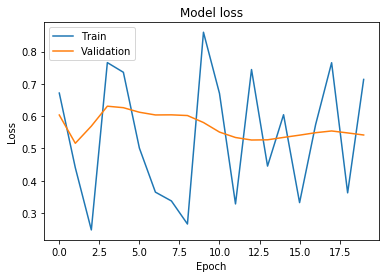

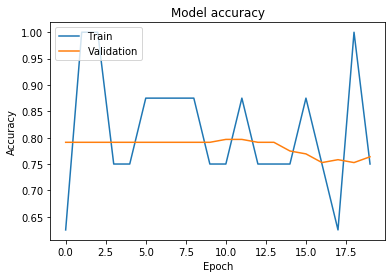

6/6 [==============================] - 0s 2ms/step


In [58]:
verbose, epoch, batch_size = 1, 100, 4
activationFunction='relu'

def VGGNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = VGGNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

vgg_acc_c = accuracy_score(y_pred, y_test)
vgg_roc_c = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
vgg_prec_c = precision_score(y_pred, y_test)
vgg_rec_c = recall_score(y_pred, y_test)
vgg_f1_c = f1_score(y_pred, y_test)
vgg_mcc_c = matthews_corrcoef(y_pred, y_test)
vgg_kap_c = cohen_kappa_score(y_pred, y_test)
vgg_jacc_c = jaccard_score(y_pred, y_test)
vgg_gmea_c = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP - VGGNets',vgg_acc_c,vgg_roc_c,vgg_prec_c,vgg_rec_c,vgg_f1_c,vgg_mcc_c,vgg_kap_c,vgg_jacc_c,vgg_gmea_c)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 399, 128)          384       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 199, 128)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 25472)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 50946     
Total params: 51,330
Trainable params: 51,330
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 153ms/step - loss: 0.6317 - accuracy: 0.8750 - val_loss: 0.5166

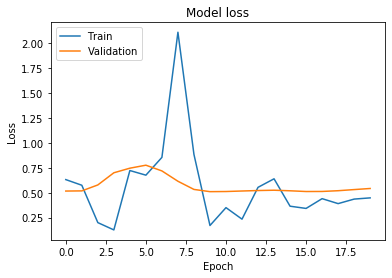

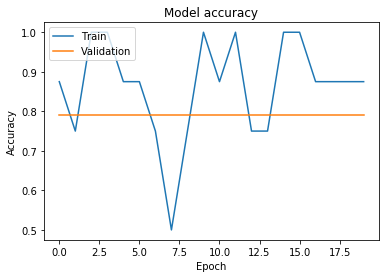

6/6 [==============================] - 0s 910us/step


In [59]:
def ResNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = ResNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

res_acc_c = accuracy_score(y_pred, y_test)
res_roc_c = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
res_prec_c = precision_score(y_pred, y_test)
res_rec_c = recall_score(y_pred, y_test)
res_f1_c = f1_score(y_pred, y_test)
res_mcc_c = matthews_corrcoef(y_pred, y_test)
res_kap_c = cohen_kappa_score(y_pred, y_test)
res_jacc_c = jaccard_score(y_pred, y_test)
res_gmea_c = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP - ResNets',res_acc_c,res_roc_c,res_prec_c,res_rec_c,res_f1_c,res_mcc_c,res_kap_c,res_jacc_c,res_gmea_c)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 399, 128)          384       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 199, 128)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 25472)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 50946     
Total params: 51,330
Trainable params: 51,330
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 151ms/step - loss: 0.5938 - accuracy: 0.7500 - val_loss: 0.5130

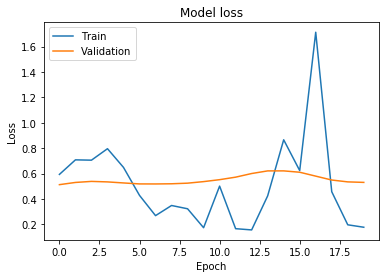

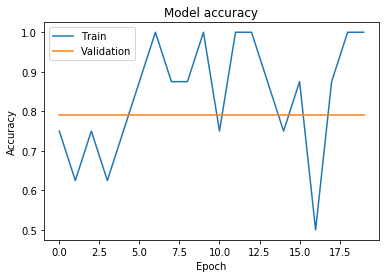

6/6 [==============================] - 0s 1ms/step


In [60]:
def DenseNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = DenseNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

dense_acc_c = accuracy_score(y_pred, y_test)
dense_roc_c = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
dense_prec_c = precision_score(y_pred, y_test)
dense_rec_c = recall_score(y_pred, y_test)
dense_f1_c = f1_score(y_pred, y_test)
dense_mcc_c = matthews_corrcoef(y_pred, y_test)
dense_kap_c = cohen_kappa_score(y_pred, y_test)
dense_jacc_c = jaccard_score(y_pred, y_test)
dense_gmea_c = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP - DenseNets',dense_acc_c,dense_roc_c,dense_prec_c,dense_rec_c,dense_f1_c,dense_mcc_c,dense_kap_c,dense_jacc_c,dense_gmea_c)

# CNV

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(CNV, y_multimodal, test_size = 0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((907, 200), (907,), (161, 200), (161,))

In [62]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm_acc_d = accuracy_score(y_pred, y_test)
svm_roc_d = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm_prec_d = precision_score(y_pred, y_test)
svm_rec_d = recall_score(y_pred, y_test)
svm_f1_d = f1_score(y_pred, y_test)
svm_mcc_d = matthews_corrcoef(y_pred, y_test)
svm_kap_d = cohen_kappa_score(y_pred, y_test)
svm_jacc_d = jaccard_score(y_pred, y_test)
svm_gmea_d = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV - SVM - rbf',svm_acc_d,svm_roc_d,svm_prec_d,svm_rec_d,svm_f1_d,svm_mcc_d,svm_kap_d,svm_jacc_d,svm_gmea_d)

In [63]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm1_acc_d = accuracy_score(y_pred, y_test)
svm1_roc_d = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm1_prec_d = precision_score(y_pred, y_test)
svm1_rec_d = recall_score(y_pred, y_test)
svm1_f1_d = f1_score(y_pred, y_test)
svm1_mcc_d = matthews_corrcoef(y_pred, y_test)
svm1_kap_d = cohen_kappa_score(y_pred, y_test)
svm1_jacc_d = jaccard_score(y_pred, y_test)
svm1_gmea_d = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV - SVM - Poly',svm1_acc_d,svm1_roc_d,svm1_prec_d,svm1_rec_d,svm1_f1_d,svm1_mcc_d,svm1_kap_d,svm1_jacc_d,svm1_gmea_d)

In [64]:
clf = SVC(C=c,kernel=utility_kernel, probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm2_acc_d = accuracy_score(y_pred, y_test)
svm2_roc_d = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm2_prec_d = precision_score(y_pred, y_test)
svm2_rec_d = recall_score(y_pred, y_test)
svm2_f1_d = f1_score(y_pred, y_test)
svm2_mcc_d = matthews_corrcoef(y_pred, y_test)
svm2_kap_d = cohen_kappa_score(y_pred, y_test)
svm2_jacc_d = jaccard_score(y_pred, y_test)
svm2_gmea_d = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV - SVM - Utility ',svm2_acc_d,svm2_roc_d,svm2_prec_d,svm2_rec_d,svm2_f1_d,svm2_mcc_d,svm2_kap_d,svm2_jacc_d,svm2_gmea_d)

In [65]:
clf = SVC(kernel ='linear', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm3_acc_d = accuracy_score(y_pred, y_test)
svm3_roc_d = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm3_prec_d = precision_score(y_pred, y_test)
svm3_rec_d = recall_score(y_pred, y_test)
svm3_f1_d = f1_score(y_pred, y_test)
svm3_mcc_d = matthews_corrcoef(y_pred, y_test)
svm3_kap_d = cohen_kappa_score(y_pred, y_test)
svm3_jacc_d = jaccard_score(y_pred, y_test)
svm3_gmea_d = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV - SVM - Linear ',svm3_acc_d,svm3_roc_d,svm3_prec_d,svm3_rec_d,svm3_f1_d,svm3_mcc_d,svm3_kap_d,svm3_jacc_d,svm3_gmea_d)

In [66]:
clf = SVC(kernel ='sigmoid', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm4_acc_d = accuracy_score(y_pred, y_test)
svm4_roc_d = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm4_prec_d = precision_score(y_pred, y_test)
svm4_rec_d = recall_score(y_pred, y_test)
svm4_f1_d = f1_score(y_pred, y_test)
svm4_mcc_d = matthews_corrcoef(y_pred, y_test)
svm4_kap_d = cohen_kappa_score(y_pred, y_test)
svm4_jacc_d = jaccard_score(y_pred, y_test)
svm4_gmea_d = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV - SVM - Sigmoid',svm4_acc_d,svm4_roc_d,svm4_prec_d,svm4_rec_d,svm4_f1_d,svm4_mcc_d,svm4_kap_d,svm4_jacc_d,svm4_gmea_d)

In [67]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model 
rf = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

rf_acc_d = accuracy_score(y_pred, y_test)
rf_roc_d = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
rf_prec_d = precision_score(y_pred, y_test)
rf_rec_d = recall_score(y_pred, y_test)
rf_f1_d = f1_score(y_pred, y_test)
rf_mcc_d = matthews_corrcoef(y_pred, y_test)
rf_kap_d = cohen_kappa_score(y_pred, y_test)
rf_jacc_d = jaccard_score(y_pred, y_test)
rf_gmea_d = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV - RF',rf_acc_d,rf_roc_d,rf_prec_d,rf_rec_d,rf_f1_d,rf_mcc_d,rf_kap_d,rf_jacc_d,rf_gmea_d)

In [68]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)

dt_acc_d = accuracy_score(y_pred, y_test)
dt_roc_d = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
dt_prec_d = precision_score(y_pred, y_test)
dt_rec_d = recall_score(y_pred, y_test)
dt_f1_d = f1_score(y_pred, y_test)
dt_mcc_d = matthews_corrcoef(y_pred, y_test)
dt_kap_d = cohen_kappa_score(y_pred, y_test)
dt_jacc_d = jaccard_score(y_pred, y_test)
dt_gmea_d = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV - DT',dt_acc_d,dt_roc_d,dt_prec_d,dt_rec_d,dt_f1_d,dt_mcc_d,dt_kap_d,dt_jacc_d,dt_gmea_d)

In [69]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.pipeline import Pipeline

# instantiate the model
nb=  GaussianNB()

# fit the model 
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
y_prob = nb.predict_proba(X_test)

nb_acc_d = accuracy_score(y_pred, y_test)
nb_roc_d = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
nb_prec_d = precision_score(y_pred, y_test)
nb_rec_d = recall_score(y_pred, y_test)
nb_f1_d = f1_score(y_pred, y_test)
nb_mcc_d = matthews_corrcoef(y_pred, y_test)
nb_kap_d = cohen_kappa_score(y_pred, y_test)
nb_jacc_d = jaccard_score(y_pred, y_test)
nb_gmea_d = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV - NB',nb_acc_d,nb_roc_d,nb_prec_d,nb_rec_d,nb_f1_d,nb_mcc_d,nb_kap_d,nb_jacc_d,nb_gmea_d)

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2 = SVC(probability=True)
clf3 = DecisionTreeClassifier(max_depth=30)

eclf1 = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train, y_train)

y_pred = eclf1.predict(X_test)
y_prob = eclf1.predict_proba(X_test)

vot_acc_d = accuracy_score(y_pred, y_test)
vot_roc_d = roc_auc_score(y_test, eclf1.predict_proba(X_test)[:, 1])
vot_prec_d = precision_score(y_pred, y_test)
vot_rec_d = recall_score(y_pred, y_test)
vot_f1_d = f1_score(y_pred, y_test)
vot_mcc_d = matthews_corrcoef(y_pred, y_test)
vot_kap_d = cohen_kappa_score(y_pred, y_test)
vot_jacc_d = jaccard_score(y_pred, y_test)
vot_gmea_d = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV - vot',vot_acc_d,vot_roc_d,vot_prec_d,vot_rec_d,vot_f1_d,vot_mcc_d,vot_kap_d,vot_jacc_d,vot_gmea_d)

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

X_train=X_train
X_test=X_test

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 199, 128)          384       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 99, 128)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 99, 128)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 12672)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 25346     
Total params: 25,730
Trainable params: 25,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 145ms/step - loss: 0.7323 - accuracy: 0.2500 - val_loss: 0.7603

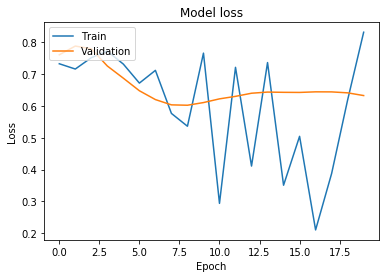

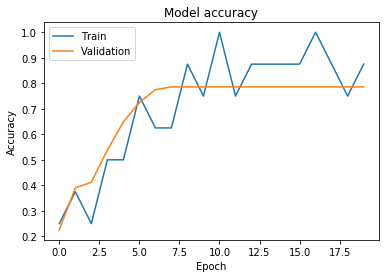

6/6 [==============================] - 0s 2ms/step


In [72]:
verbose, epoch, batch_size = 1, 100, 4
activationFunction='relu'

def VGGNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = VGGNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

vgg_acc_d = accuracy_score(y_pred, y_test)
vgg_roc_d = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
vgg_prec_d = precision_score(y_pred, y_test)
vgg_rec_d = recall_score(y_pred, y_test)
vgg_f1_d = f1_score(y_pred, y_test)
vgg_mcc_d = matthews_corrcoef(y_pred, y_test)
vgg_kap_d = cohen_kappa_score(y_pred, y_test)
vgg_jacc_d = jaccard_score(y_pred, y_test)
vgg_gmea_d = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV - VGGNets',vgg_acc_d,vgg_roc_d,vgg_prec_d,vgg_rec_d,vgg_f1_d,vgg_mcc_d,vgg_kap_d,vgg_jacc_d,vgg_gmea_d)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 199, 128)          384       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 99, 128)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 99, 128)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 12672)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 25346     
Total params: 25,730
Trainable params: 25,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 150ms/step - loss: 0.6994 - accuracy: 0.3750 - val_loss: 0.667

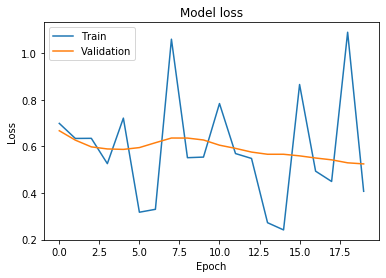

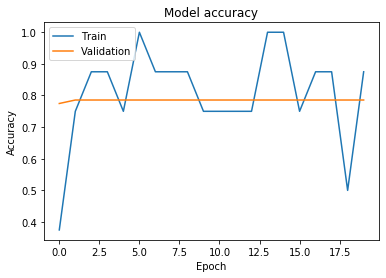

6/6 [==============================] - 0s 997us/step


In [73]:
def ResNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = ResNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

res_acc_d = accuracy_score(y_pred, y_test)
res_roc_d = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
res_prec_d = precision_score(y_pred, y_test)
res_rec_d = recall_score(y_pred, y_test)
res_f1_d = f1_score(y_pred, y_test)
res_mcc_d = matthews_corrcoef(y_pred, y_test)
res_kap_d = cohen_kappa_score(y_pred, y_test)
res_jacc_d = jaccard_score(y_pred, y_test)
res_gmea_d = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV - ResNets',res_acc_d,res_roc_d,res_prec_d,res_rec_d,res_f1_d,res_mcc_d,res_kap_d,res_jacc_d,res_gmea_d)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 199, 128)          384       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 99, 128)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 99, 128)           0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 12672)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 25346     
Total params: 25,730
Trainable params: 25,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 149ms/step - loss: 0.6458 - accuracy: 0.5000 - val_loss: 0.624

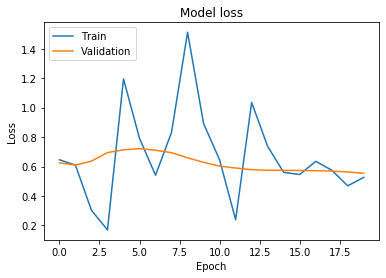

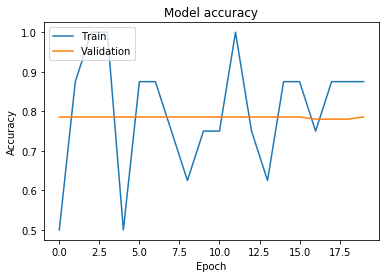

6/6 [==============================] - 0s 997us/step


In [74]:
def DenseNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = DenseNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

dense_acc_d = accuracy_score(y_pred, y_test)
dense_roc_d = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
dense_prec_d = precision_score(y_pred, y_test)
dense_rec_d = recall_score(y_pred, y_test)
dense_f1_d = f1_score(y_pred, y_test)
dense_mcc_d = matthews_corrcoef(y_pred, y_test)
dense_kap_d = cohen_kappa_score(y_pred, y_test)
dense_jacc_d = jaccard_score(y_pred, y_test)
dense_gmea_d = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV - DenseNets',dense_acc_d,dense_roc_d,dense_prec_d,dense_rec_d,dense_f1_d,dense_mcc_d,dense_kap_d,dense_jacc_d,dense_gmea_d)

# CLN - EXP

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(CLN_EXP, y_multimodal, test_size = 0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((907, 410), (907,), (161, 410), (161,))

In [76]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm_acc_e = accuracy_score(y_pred, y_test)
svm_roc_e = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm_prec_e = precision_score(y_pred, y_test)
svm_rec_e = recall_score(y_pred, y_test)
svm_f1_e = f1_score(y_pred, y_test)
svm_mcc_e = matthews_corrcoef(y_pred, y_test)
svm_kap_e = cohen_kappa_score(y_pred, y_test)
svm_jacc_e = jaccard_score(y_pred, y_test)
svm_gmea_e = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP - SVM - rbf',svm_acc_e,svm_roc_e,svm_prec_e,svm_rec_e,svm_f1_e,svm_mcc_e,svm_kap_e,svm_jacc_e,svm_gmea_e)

In [77]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm1_acc_e = accuracy_score(y_pred, y_test)
svm1_roc_e = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm1_prec_e = precision_score(y_pred, y_test)
svm1_rec_e = recall_score(y_pred, y_test)
svm1_f1_e = f1_score(y_pred, y_test)
svm1_mcc_e = matthews_corrcoef(y_pred, y_test)
svm1_kap_e = cohen_kappa_score(y_pred, y_test)
svm1_jacc_e = jaccard_score(y_pred, y_test)
svm1_gmea_e = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP - SVM - Poly',svm1_acc_e,svm1_roc_e,svm1_prec_e,svm1_rec_e,svm1_f1_e,svm1_mcc_e,svm1_kap_e,svm1_jacc_e,svm1_gmea_e)

In [78]:
clf = SVC(C=c,kernel=utility_kernel, probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm2_acc_e = accuracy_score(y_pred, y_test)
svm2_roc_e = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm2_prec_e = precision_score(y_pred, y_test)
svm2_rec_e = recall_score(y_pred, y_test)
svm2_f1_e = f1_score(y_pred, y_test)
svm2_mcc_e = matthews_corrcoef(y_pred, y_test)
svm2_kap_e = cohen_kappa_score(y_pred, y_test)
svm2_jacc_e = jaccard_score(y_pred, y_test)
svm2_gmea_e = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP - SVM - Utility ',svm2_acc_e,svm2_roc_e,svm2_prec_e,svm2_rec_e,svm2_f1_e,svm2_mcc_e,svm2_kap_e,svm2_jacc_e,svm2_gmea_e)

In [79]:
clf = SVC(kernel ='linear', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm3_acc_e = accuracy_score(y_pred, y_test)
svm3_roc_e = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm3_prec_e = precision_score(y_pred, y_test)
svm3_rec_e = recall_score(y_pred, y_test)
svm3_f1_e = f1_score(y_pred, y_test)
svm3_mcc_e = matthews_corrcoef(y_pred, y_test)
svm3_kap_e = cohen_kappa_score(y_pred, y_test)
svm3_jacc_e = jaccard_score(y_pred, y_test)
svm3_gmea_e = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP - SVM - Linear ',svm3_acc_e,svm3_roc_e,svm3_prec_e,svm3_rec_e,svm3_f1_e,svm3_mcc_e,svm3_kap_e,svm3_jacc_e,svm3_gmea_e)

In [80]:
clf = SVC(kernel ='sigmoid', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm4_acc_e = accuracy_score(y_pred, y_test)
svm4_roc_e = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm4_prec_e = precision_score(y_pred, y_test)
svm4_rec_e = recall_score(y_pred, y_test)
svm4_f1_e = f1_score(y_pred, y_test)
svm4_mcc_e = matthews_corrcoef(y_pred, y_test)
svm4_kap_e = cohen_kappa_score(y_pred, y_test)
svm4_jacc_e = jaccard_score(y_pred, y_test)
svm4_gmea_e = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP - SVM - Sigmoid',svm4_acc_e,svm4_roc_e,svm4_prec_e,svm4_rec_e,svm4_f1_e,svm4_mcc_e,svm4_kap_e,svm4_jacc_e,svm4_gmea_e)

In [81]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model 
rf = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

rf_acc_e = accuracy_score(y_pred, y_test)
rf_roc_e = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
rf_prec_e = precision_score(y_pred, y_test)
rf_rec_e = recall_score(y_pred, y_test)
rf_f1_e = f1_score(y_pred, y_test)
rf_mcc_e = matthews_corrcoef(y_pred, y_test)
rf_kap_e = cohen_kappa_score(y_pred, y_test)
rf_jacc_e = jaccard_score(y_pred, y_test)
rf_gmea_e = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP - RF',rf_acc_e,rf_roc_e,rf_prec_e,rf_rec_e,rf_f1_e,rf_mcc_e,rf_kap_e,rf_jacc_e,rf_gmea_e)

In [82]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)

dt_acc_e = accuracy_score(y_pred, y_test)
dt_roc_e = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
dt_prec_e = precision_score(y_pred, y_test)
dt_rec_e = recall_score(y_pred, y_test)
dt_f1_e = f1_score(y_pred, y_test)
dt_mcc_e = matthews_corrcoef(y_pred, y_test)
dt_kap_e = cohen_kappa_score(y_pred, y_test)
dt_jacc_e = jaccard_score(y_pred, y_test)
dt_gmea_e = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP - DT',dt_acc_e,dt_roc_e,dt_prec_e,dt_rec_e,dt_f1_e,dt_mcc_e,dt_kap_e,dt_jacc_e,dt_gmea_e)

In [83]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.pipeline import Pipeline

# instantiate the model
nb=  GaussianNB()

# fit the model 
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
y_prob = nb.predict_proba(X_test)

nb_acc_e = accuracy_score(y_pred, y_test)
nb_roc_e = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
nb_prec_e = precision_score(y_pred, y_test)
nb_rec_e = recall_score(y_pred, y_test)
nb_f1_e = f1_score(y_pred, y_test)
nb_mcc_e = matthews_corrcoef(y_pred, y_test)
nb_kap_e = cohen_kappa_score(y_pred, y_test)
nb_jacc_e = jaccard_score(y_pred, y_test)
nb_gmea_e = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP - NB',nb_acc_e,nb_roc_e,nb_prec_e,nb_rec_e,nb_f1_e,nb_mcc_e,nb_kap_e,nb_jacc_e,nb_gmea_e)

In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2 = SVC(probability=True)
clf3 = DecisionTreeClassifier(max_depth=30)

eclf1 = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train, y_train)

y_pred = eclf1.predict(X_test)
y_prob = eclf1.predict_proba(X_test)

vot_acc_e = accuracy_score(y_pred, y_test)
vot_roc_e = roc_auc_score(y_test, eclf1.predict_proba(X_test)[:, 1])
vot_prec_e = precision_score(y_pred, y_test)
vot_rec_e = recall_score(y_pred, y_test)
vot_f1_e = f1_score(y_pred, y_test)
vot_mcc_e = matthews_corrcoef(y_pred, y_test)
vot_kap_e = cohen_kappa_score(y_pred, y_test)
vot_jacc_e = jaccard_score(y_pred, y_test)
vot_gmea_e = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP - vot',vot_acc_e,vot_roc_e,vot_prec_e,vot_rec_e,vot_f1_e,vot_mcc_e,vot_kap_e,vot_jacc_e,vot_gmea_e)

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

X_train=X_train
X_test=X_test

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 409, 128)          384       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 204, 128)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 204, 128)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 26112)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 52226     
Total params: 52,610
Trainable params: 52,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 160ms/step - loss: 0.6806 - accuracy: 0.6250 - val_loss: 0.605

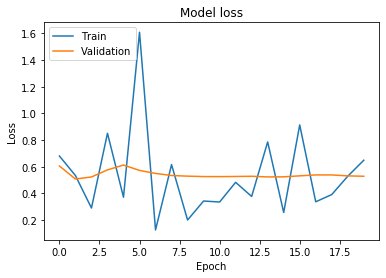

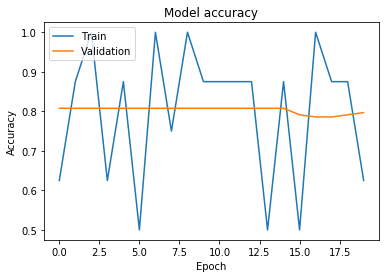

6/6 [==============================] - 0s 1ms/step


In [86]:
verbose, epoch, batch_size = 1, 100, 4
activationFunction='relu'

def VGGNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = VGGNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

vgg_acc_e = accuracy_score(y_pred, y_test)
vgg_roc_e = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
vgg_prec_e = precision_score(y_pred, y_test)
vgg_rec_e = recall_score(y_pred, y_test)
vgg_f1_e = f1_score(y_pred, y_test)
vgg_mcc_e = matthews_corrcoef(y_pred, y_test)
vgg_kap_e = cohen_kappa_score(y_pred, y_test)
vgg_jacc_e = jaccard_score(y_pred, y_test)
vgg_gmea_e = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP - VGGNets',vgg_acc_e,vgg_roc_e,vgg_prec_e,vgg_rec_e,vgg_f1_e,vgg_mcc_e,vgg_kap_e,vgg_jacc_e,vgg_gmea_e)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 409, 128)          384       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 204, 128)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 204, 128)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 26112)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 52226     
Total params: 52,610
Trainable params: 52,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 156ms/step - loss: 0.5825 - accuracy: 0.5000 - val_loss: 0.499

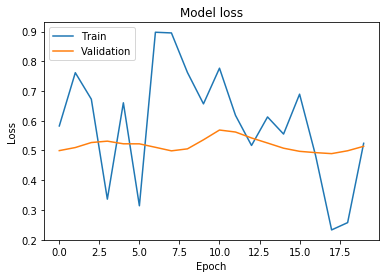

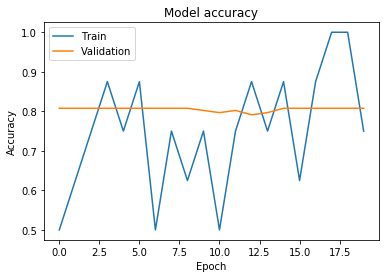

6/6 [==============================] - 0s 2ms/step


In [87]:
def ResNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = ResNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

res_acc_e = accuracy_score(y_pred, y_test)
res_roc_e = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
res_prec_e = precision_score(y_pred, y_test)
res_rec_e = recall_score(y_pred, y_test)
res_f1_e = f1_score(y_pred, y_test)
res_mcc_e = matthews_corrcoef(y_pred, y_test)
res_kap_e = cohen_kappa_score(y_pred, y_test)
res_jacc_e = jaccard_score(y_pred, y_test)
res_gmea_e = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP - ResNets',res_acc_e,res_roc_e,res_prec_e,res_rec_e,res_f1_e,res_mcc_e,res_kap_e,res_jacc_e,res_gmea_e)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 409, 128)          384       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 204, 128)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 204, 128)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 26112)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 52226     
Total params: 52,610
Trainable params: 52,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 157ms/step - loss: 0.5962 - accuracy: 0.8750 - val_loss: 0.524

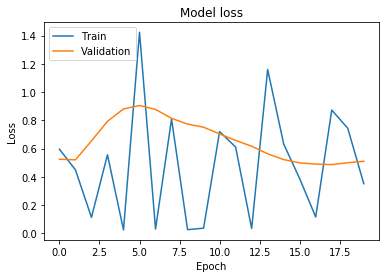

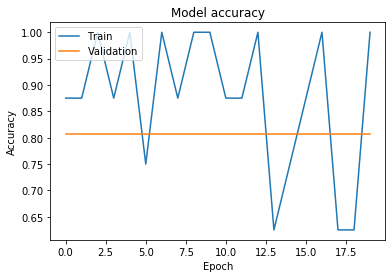

6/6 [==============================] - 0s 1ms/step


In [88]:
def DenseNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = DenseNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

dense_acc_e = accuracy_score(y_pred, y_test)
dense_roc_e = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
dense_prec_e = precision_score(y_pred, y_test)
dense_rec_e = recall_score(y_pred, y_test)
dense_f1_e = f1_score(y_pred, y_test)
dense_mcc_e = matthews_corrcoef(y_pred, y_test)
dense_kap_e = cohen_kappa_score(y_pred, y_test)
dense_jacc_e = jaccard_score(y_pred, y_test)
dense_gmea_e = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP - DenseNets',dense_acc_e,dense_roc_e,dense_prec_e,dense_rec_e,dense_f1_e,dense_mcc_e,dense_kap_e,dense_jacc_e,dense_gmea_e)

# CLN-CNV

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(CLN_CNV, y_multimodal, test_size = 0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((907, 210), (907,), (161, 210), (161,))

In [90]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm_acc_f = accuracy_score(y_pred, y_test)
svm_roc_f = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm_prec_f = precision_score(y_pred, y_test)
svm_rec_f = recall_score(y_pred, y_test)
svm_f1_f = f1_score(y_pred, y_test)
svm_mcc_f = matthews_corrcoef(y_pred, y_test)
svm_kap_f = cohen_kappa_score(y_pred, y_test)
svm_jacc_f = jaccard_score(y_pred, y_test)
svm_gmea_f = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-CNV - SVM - rbf',svm_acc_f,svm_roc_f,svm_prec_f,svm_rec_f,svm_f1_f,svm_mcc_f,svm_kap_f,svm_jacc_f,svm_gmea_f)

In [91]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm1_acc_f = accuracy_score(y_pred, y_test)
svm1_roc_f = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm1_prec_f = precision_score(y_pred, y_test)
svm1_rec_f = recall_score(y_pred, y_test)
svm1_f1_f = f1_score(y_pred, y_test)
svm1_mcc_f = matthews_corrcoef(y_pred, y_test)
svm1_kap_f = cohen_kappa_score(y_pred, y_test)
svm1_jacc_f = jaccard_score(y_pred, y_test)
svm1_gmea_f = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-CNV - SVM - Poly',svm1_acc_f,svm1_roc_f,svm1_prec_f,svm1_rec_f,svm1_f1_f,svm1_mcc_f,svm1_kap_f,svm1_jacc_f,svm1_gmea_f)

In [92]:
clf = SVC(C=c,kernel=utility_kernel, probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm2_acc_f = accuracy_score(y_pred, y_test)
svm2_roc_f = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm2_prec_f = precision_score(y_pred, y_test)
svm2_rec_f = recall_score(y_pred, y_test)
svm2_f1_f = f1_score(y_pred, y_test)
svm2_mcc_f = matthews_corrcoef(y_pred, y_test)
svm2_kap_f = cohen_kappa_score(y_pred, y_test)
svm2_jacc_f = jaccard_score(y_pred, y_test)
svm2_gmea_f = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-CNV - SVM - Utility ',svm2_acc_f,svm2_roc_f,svm2_prec_f,svm2_rec_f,svm2_f1_f,svm2_mcc_f,svm2_kap_f,svm2_jacc_f,svm2_gmea_f)

In [93]:
clf = SVC(kernel ='linear', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm3_acc_f = accuracy_score(y_pred, y_test)
svm3_roc_f = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm3_prec_f = precision_score(y_pred, y_test)
svm3_rec_f = recall_score(y_pred, y_test)
svm3_f1_f = f1_score(y_pred, y_test)
svm3_mcc_f = matthews_corrcoef(y_pred, y_test)
svm3_kap_f = cohen_kappa_score(y_pred, y_test)
svm3_jacc_f = jaccard_score(y_pred, y_test)
svm3_gmea_f = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-CNV - SVM - Linear ',svm3_acc_f,svm3_roc_f,svm3_prec_f,svm3_rec_f,svm3_f1_f,svm3_mcc_f,svm3_kap_f,svm3_jacc_f,svm3_gmea_f)

In [94]:
clf = SVC(kernel ='sigmoid', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm4_acc_f = accuracy_score(y_pred, y_test)
svm4_roc_f = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm4_prec_f = precision_score(y_pred, y_test)
svm4_rec_f = recall_score(y_pred, y_test)
svm4_f1_f = f1_score(y_pred, y_test)
svm4_mcc_f = matthews_corrcoef(y_pred, y_test)
svm4_kap_f = cohen_kappa_score(y_pred, y_test)
svm4_jacc_f = jaccard_score(y_pred, y_test)
svm4_gmea_f = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-CNV - SVM - Sigmoid',svm4_acc_f,svm4_roc_f,svm4_prec_f,svm4_rec_f,svm4_f1_f,svm4_mcc_f,svm4_kap_f,svm4_jacc_f,svm4_gmea_f)

In [95]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model 
rf = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

rf_acc_f = accuracy_score(y_pred, y_test)
rf_roc_f = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
rf_prec_f = precision_score(y_pred, y_test)
rf_rec_f = recall_score(y_pred, y_test)
rf_f1_f = f1_score(y_pred, y_test)
rf_mcc_f = matthews_corrcoef(y_pred, y_test)
rf_kap_f = cohen_kappa_score(y_pred, y_test)
rf_jacc_f = jaccard_score(y_pred, y_test)
rf_gmea_f = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-CNV - RF',rf_acc_f,rf_roc_f,rf_prec_f,rf_rec_f,rf_f1_f,rf_mcc_f,rf_kap_f,rf_jacc_f,rf_gmea_f)

In [96]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)

dt_acc_f = accuracy_score(y_pred, y_test)
dt_roc_f = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
dt_prec_f = precision_score(y_pred, y_test)
dt_rec_f = recall_score(y_pred, y_test)
dt_f1_f = f1_score(y_pred, y_test)
dt_mcc_f = matthews_corrcoef(y_pred, y_test)
dt_kap_f = cohen_kappa_score(y_pred, y_test)
dt_jacc_f = jaccard_score(y_pred, y_test)
dt_gmea_f = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-CNV - DT',dt_acc_f,dt_roc_f,dt_prec_f,dt_rec_f,dt_f1_f,dt_mcc_f,dt_kap_f,dt_jacc_f,dt_gmea_f)

In [97]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.pipeline import Pipeline

# instantiate the model
nb=  GaussianNB()

# fit the model 
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
y_prob = nb.predict_proba(X_test)

nb_acc_f = accuracy_score(y_pred, y_test)
nb_roc_f = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
nb_prec_f = precision_score(y_pred, y_test)
nb_rec_f = recall_score(y_pred, y_test)
nb_f1_f = f1_score(y_pred, y_test)
nb_mcc_f = matthews_corrcoef(y_pred, y_test)
nb_kap_f = cohen_kappa_score(y_pred, y_test)
nb_jacc_f = jaccard_score(y_pred, y_test)
nb_gmea_f = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-CNV - NB',nb_acc_f,nb_roc_f,nb_prec_f,nb_rec_f,nb_f1_f,nb_mcc_f,nb_kap_f,nb_jacc_f,nb_gmea_f)

In [98]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2 = SVC(probability=True)
clf3 = DecisionTreeClassifier(max_depth=30)

eclf1 = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train, y_train)

y_pred = eclf1.predict(X_test)
y_prob = eclf1.predict_proba(X_test)

vot_acc_f = accuracy_score(y_pred, y_test)
vot_roc_f = roc_auc_score(y_test, eclf1.predict_proba(X_test)[:, 1])
vot_prec_f = precision_score(y_pred, y_test)
vot_rec_f = recall_score(y_pred, y_test)
vot_f1_f = f1_score(y_pred, y_test)
vot_mcc_f = matthews_corrcoef(y_pred, y_test)
vot_kap_f = cohen_kappa_score(y_pred, y_test)
vot_jacc_f = jaccard_score(y_pred, y_test)
vot_gmea_f = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-CNV - vot',vot_acc_f,vot_roc_f,vot_prec_f,vot_rec_f,vot_f1_f,vot_mcc_f,vot_kap_f,vot_jacc_f,vot_gmea_f)

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

X_train=X_train
X_test=X_test

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 209, 128)          384       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 104, 128)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 104, 128)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 13312)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 26626     
Total params: 27,010
Trainable params: 27,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 1s 148ms/step - loss: 0.6534 - accuracy: 0.8750 - val_loss: 0.571

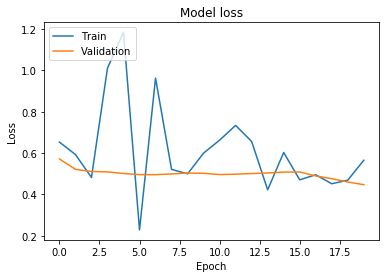

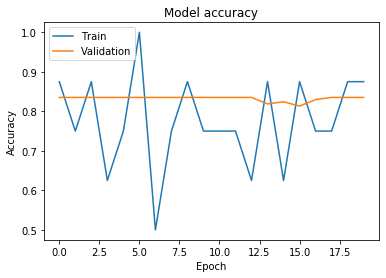

6/6 [==============================] - 0s 1ms/step


In [100]:
verbose, epoch, batch_size = 1, 100, 4
activationFunction='relu'

def VGGNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = VGGNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

vgg_acc_f = accuracy_score(y_pred, y_test)
vgg_roc_f = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
vgg_prec_f = precision_score(y_pred, y_test)
vgg_rec_f = recall_score(y_pred, y_test)
vgg_f1_f = f1_score(y_pred, y_test)
vgg_mcc_f = matthews_corrcoef(y_pred, y_test)
vgg_kap_f = cohen_kappa_score(y_pred, y_test)
vgg_jacc_f = jaccard_score(y_pred, y_test)
vgg_gmea_f = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-CNV - VGGNets',vgg_acc_f,vgg_roc_f,vgg_prec_f,vgg_rec_f,vgg_f1_f,vgg_mcc_f,vgg_kap_f,vgg_jacc_f,vgg_gmea_f)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 209, 128)          384       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 104, 128)          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 104, 128)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 13312)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 26626     
Total params: 27,010
Trainable params: 27,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 146ms/step - loss: 0.7302 - accuracy: 0.3750 - val_loss: 0.606

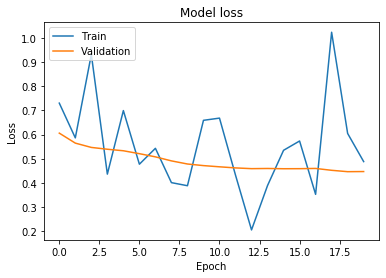

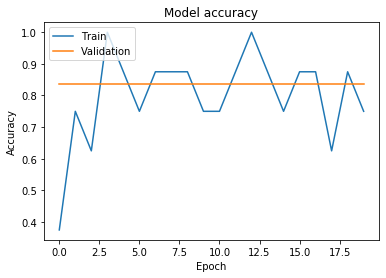

6/6 [==============================] - 0s 1ms/step


In [101]:
def ResNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = ResNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

res_acc_f = accuracy_score(y_pred, y_test)
res_roc_f = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
res_prec_f = precision_score(y_pred, y_test)
res_rec_f = recall_score(y_pred, y_test)
res_f1_f = f1_score(y_pred, y_test)
res_mcc_f = matthews_corrcoef(y_pred, y_test)
res_kap_f = cohen_kappa_score(y_pred, y_test)
res_jacc_f = jaccard_score(y_pred, y_test)
res_gmea_f = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-CNV - ResNets',res_acc_f,res_roc_f,res_prec_f,res_rec_f,res_f1_f,res_mcc_f,res_kap_f,res_jacc_f,res_gmea_f)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 209, 128)          384       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 104, 128)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 104, 128)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 13312)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 26626     
Total params: 27,010
Trainable params: 27,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 156ms/step - loss: 0.6552 - accuracy: 0.7500 - val_loss: 0.578

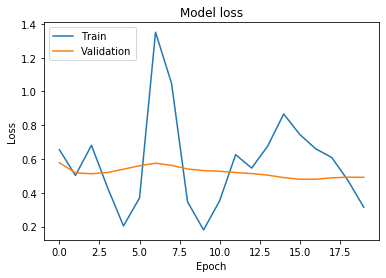

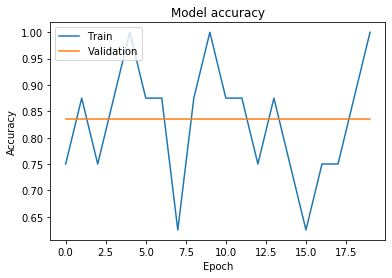

6/6 [==============================] - 0s 2ms/step


In [102]:
def DenseNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = DenseNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

dense_acc_f = accuracy_score(y_pred, y_test)
dense_roc_f = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
dense_prec_f = precision_score(y_pred, y_test)
dense_rec_f = recall_score(y_pred, y_test)
dense_f1_f = f1_score(y_pred, y_test)
dense_mcc_f = matthews_corrcoef(y_pred, y_test)
dense_kap_f = cohen_kappa_score(y_pred, y_test)
dense_jacc_f = jaccard_score(y_pred, y_test)
dense_gmea_f = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-CNV - DenseNets',dense_acc_f,dense_roc_f,dense_prec_f,dense_rec_f,dense_f1_f,dense_mcc_f,dense_kap_f,dense_jacc_f,dense_gmea_f)

# CLN-WSI

In [103]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(CLN_WSI, y_multimodal, test_size = 0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((907, 810), (907,), (161, 810), (161,))

In [104]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm_acc_g = accuracy_score(y_pred, y_test)
svm_roc_g = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm_prec_g = precision_score(y_pred, y_test)
svm_rec_g = recall_score(y_pred, y_test)
svm_f1_g = f1_score(y_pred, y_test)
svm_mcc_g = matthews_corrcoef(y_pred, y_test)
svm_kap_g = cohen_kappa_score(y_pred, y_test)
svm_jacc_g = jaccard_score(y_pred, y_test)
svm_gmea_g = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI - SVM - rbf',svm_acc_g,svm_roc_g,svm_prec_g,svm_rec_g,svm_f1_g,svm_mcc_g,svm_kap_g,svm_jacc_g,svm_gmea_g)

In [105]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm1_acc_g = accuracy_score(y_pred, y_test)
svm1_roc_g = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm1_prec_g = precision_score(y_pred, y_test)
svm1_rec_g = recall_score(y_pred, y_test)
svm1_f1_g = f1_score(y_pred, y_test)
svm1_mcc_g = matthews_corrcoef(y_pred, y_test)
svm1_kap_g = cohen_kappa_score(y_pred, y_test)
svm1_jacc_g = jaccard_score(y_pred, y_test)
svm1_gmea_g = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI - SVM - Poly',svm1_acc_g,svm1_roc_g,svm1_prec_g,svm1_rec_g,svm1_f1_g,svm1_mcc_g,svm1_kap_g,svm1_jacc_g,svm1_gmea_g)

In [106]:
clf = SVC(C=c,kernel=utility_kernel, probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm2_acc_g = accuracy_score(y_pred, y_test)
svm2_roc_g = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm2_prec_g = precision_score(y_pred, y_test)
svm2_rec_g = recall_score(y_pred, y_test)
svm2_f1_g = f1_score(y_pred, y_test)
svm2_mcc_g = matthews_corrcoef(y_pred, y_test)
svm2_kap_g = cohen_kappa_score(y_pred, y_test)
svm2_jacc_g = jaccard_score(y_pred, y_test)
svm2_gmea_g = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI - SVM - Utility ',svm2_acc_g,svm2_roc_g,svm2_prec_g,svm2_rec_g,svm2_f1_g,svm2_mcc_g,svm2_kap_g,svm2_jacc_g,svm2_gmea_g)

In [107]:
clf = SVC(kernel ='linear', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm3_acc_g = accuracy_score(y_pred, y_test)
svm3_roc_g = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm3_prec_g = precision_score(y_pred, y_test)
svm3_rec_g = recall_score(y_pred, y_test)
svm3_f1_g = f1_score(y_pred, y_test)
svm3_mcc_g = matthews_corrcoef(y_pred, y_test)
svm3_kap_g = cohen_kappa_score(y_pred, y_test)
svm3_jacc_g = jaccard_score(y_pred, y_test)
svm3_gmea_g = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI - SVM - Linear ',svm3_acc_g,svm3_roc_g,svm3_prec_g,svm3_rec_g,svm3_f1_g,svm3_mcc_g,svm3_kap_g,svm3_jacc_g,svm3_gmea_g)

In [108]:
clf = SVC(kernel ='sigmoid', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm4_acc_g = accuracy_score(y_pred, y_test)
svm4_roc_g = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm4_prec_g = precision_score(y_pred, y_test)
svm4_rec_g = recall_score(y_pred, y_test)
svm4_f1_g = f1_score(y_pred, y_test)
svm4_mcc_g = matthews_corrcoef(y_pred, y_test)
svm4_kap_g = cohen_kappa_score(y_pred, y_test)
svm4_jacc_g = jaccard_score(y_pred, y_test)
svm4_gmea_g = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI - SVM - Sigmoid',svm4_acc_g,svm4_roc_g,svm4_prec_g,svm4_rec_g,svm4_f1_g,svm4_mcc_g,svm4_kap_g,svm4_jacc_g,svm4_gmea_g)

In [109]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model 
rf = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

rf_acc_g = accuracy_score(y_pred, y_test)
rf_roc_g = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
rf_prec_g = precision_score(y_pred, y_test)
rf_rec_g = recall_score(y_pred, y_test)
rf_f1_g = f1_score(y_pred, y_test)
rf_mcc_g = matthews_corrcoef(y_pred, y_test)
rf_kap_g = cohen_kappa_score(y_pred, y_test)
rf_jacc_g = jaccard_score(y_pred, y_test)
rf_gmea_g = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI - RF',rf_acc_g,rf_roc_g,rf_prec_g,rf_rec_g,rf_f1_g,rf_mcc_g,rf_kap_g,rf_jacc_g,rf_gmea_g)

In [110]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)

dt_acc_g = accuracy_score(y_pred, y_test)
dt_roc_g = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
dt_prec_g = precision_score(y_pred, y_test)
dt_rec_g = recall_score(y_pred, y_test)
dt_f1_g = f1_score(y_pred, y_test)
dt_mcc_g = matthews_corrcoef(y_pred, y_test)
dt_kap_g = cohen_kappa_score(y_pred, y_test)
dt_jacc_g = jaccard_score(y_pred, y_test)
dt_gmea_g = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI - DT',dt_acc_g,dt_roc_g,dt_prec_g,dt_rec_g,dt_f1_g,dt_mcc_g,dt_kap_g,dt_jacc_g,dt_gmea_g)

In [111]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.pipeline import Pipeline

# instantiate the model
nb=  GaussianNB()

# fit the model 
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
y_prob = nb.predict_proba(X_test)

nb_acc_g = accuracy_score(y_pred, y_test)
nb_roc_g = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
nb_prec_g = precision_score(y_pred, y_test)
nb_rec_g = recall_score(y_pred, y_test)
nb_f1_g = f1_score(y_pred, y_test)
nb_mcc_g = matthews_corrcoef(y_pred, y_test)
nb_kap_g = cohen_kappa_score(y_pred, y_test)
nb_jacc_g = jaccard_score(y_pred, y_test)
nb_gmea_g = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI - NB',nb_acc_g,nb_roc_g,nb_prec_g,nb_rec_g,nb_f1_g,nb_mcc_g,nb_kap_g,nb_jacc_g,nb_gmea_g)

In [112]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2 = SVC(probability=True)
clf3 = DecisionTreeClassifier(max_depth=30)

eclf1 = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train, y_train)

y_pred = eclf1.predict(X_test)
y_prob = eclf1.predict_proba(X_test)

vot_acc_g = accuracy_score(y_pred, y_test)
vot_roc_g = roc_auc_score(y_test, eclf1.predict_proba(X_test)[:, 1])
vot_prec_g = precision_score(y_pred, y_test)
vot_rec_g = recall_score(y_pred, y_test)
vot_f1_g = f1_score(y_pred, y_test)
vot_mcc_g = matthews_corrcoef(y_pred, y_test)
vot_kap_g = cohen_kappa_score(y_pred, y_test)
vot_jacc_g = jaccard_score(y_pred, y_test)
vot_gmea_g = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI - vot',vot_acc_g,vot_roc_g,vot_prec_g,vot_rec_g,vot_f1_g,vot_mcc_g,vot_kap_g,vot_jacc_g,vot_gmea_g)

In [113]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

X_train=X_train
X_test=X_test

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 809, 128)          384       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 404, 128)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 404, 128)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 51712)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 103426    
Total params: 103,810
Trainable params: 103,810
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 1s 263ms/step - loss: 0.5126 - accuracy: 0.6250 - val_loss: 16.

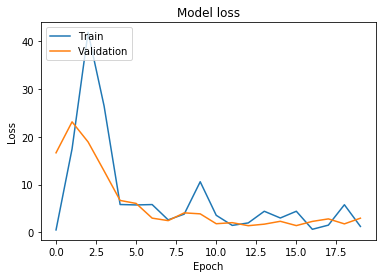

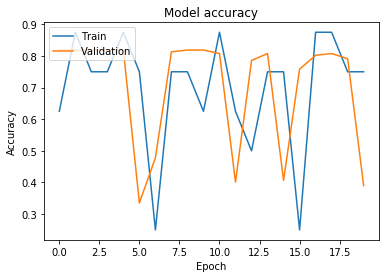

6/6 [==============================] - 0s 997us/step


In [114]:
verbose, epoch, batch_size = 1, 100, 4
activationFunction='relu'

def VGGNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = VGGNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

vgg_acc_g = accuracy_score(y_pred, y_test)
vgg_roc_g = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
vgg_prec_g = precision_score(y_pred, y_test)
vgg_rec_g = recall_score(y_pred, y_test)
vgg_f1_g = f1_score(y_pred, y_test)
vgg_mcc_g = matthews_corrcoef(y_pred, y_test)
vgg_kap_g = cohen_kappa_score(y_pred, y_test)
vgg_jacc_g = jaccard_score(y_pred, y_test)
vgg_gmea_g = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI - VGGNets',vgg_acc_g,vgg_roc_g,vgg_prec_g,vgg_rec_g,vgg_f1_g,vgg_mcc_g,vgg_kap_g,vgg_jacc_g,vgg_gmea_g)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 809, 128)          384       
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 404, 128)          0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 404, 128)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 51712)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 103426    
Total params: 103,810
Trainable params: 103,810
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 154ms/step - loss: 0.2587 - accuracy: 0.8750 - val_loss: 17.

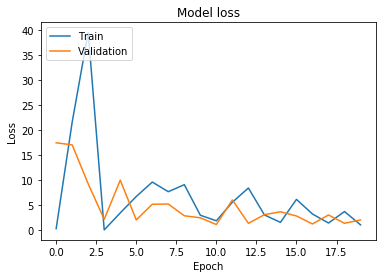

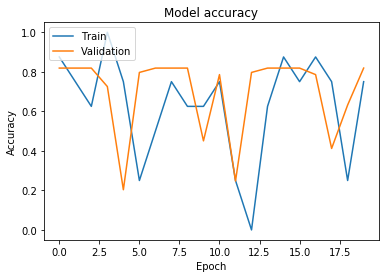

6/6 [==============================] - 0s 797us/step


In [115]:
def ResNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = ResNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

res_acc_g = accuracy_score(y_pred, y_test)
res_roc_g = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
res_prec_g = precision_score(y_pred, y_test)
res_rec_g = recall_score(y_pred, y_test)
res_f1_g = f1_score(y_pred, y_test)
res_mcc_g = matthews_corrcoef(y_pred, y_test)
res_kap_g = cohen_kappa_score(y_pred, y_test)
res_jacc_g = jaccard_score(y_pred, y_test)
res_gmea_g = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI - ResNets',res_acc_g,res_roc_g,res_prec_g,res_rec_g,res_f1_g,res_mcc_g,res_kap_g,res_jacc_g,res_gmea_g)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 809, 128)          384       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 404, 128)          0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 404, 128)          0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 51712)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 103426    
Total params: 103,810
Trainable params: 103,810
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 152ms/step - loss: 0.9742 - accuracy: 0.5000 - val_loss: 17.

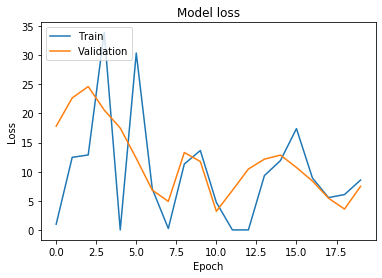

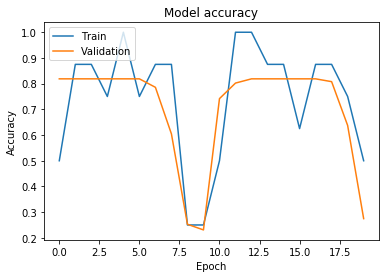

6/6 [==============================] - 0s 997us/step


In [116]:
def DenseNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = DenseNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

dense_acc_g = accuracy_score(y_pred, y_test)
dense_roc_g = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
dense_prec_g = precision_score(y_pred, y_test)
dense_rec_g = recall_score(y_pred, y_test)
dense_f1_g = f1_score(y_pred, y_test)
dense_mcc_g = matthews_corrcoef(y_pred, y_test)
dense_kap_g = cohen_kappa_score(y_pred, y_test)
dense_jacc_g = jaccard_score(y_pred, y_test)
dense_gmea_g = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI - DenseNets',dense_acc_g,dense_roc_g,dense_prec_g,dense_rec_g,dense_f1_g,dense_mcc_g,dense_kap_g,dense_jacc_g,dense_gmea_g)

# EXP-CNV

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(EXP_CNV, y_multimodal, test_size = 0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((907, 600), (907,), (161, 600), (161,))

In [118]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm_acc_h = accuracy_score(y_pred, y_test)
svm_roc_h = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm_prec_h = precision_score(y_pred, y_test)
svm_rec_h = recall_score(y_pred, y_test)
svm_f1_h = f1_score(y_pred, y_test)
svm_mcc_h = matthews_corrcoef(y_pred, y_test)
svm_kap_h = cohen_kappa_score(y_pred, y_test)
svm_jacc_h = jaccard_score(y_pred, y_test)
svm_gmea_h = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV - SVM - rbf',svm_acc_h,svm_roc_h,svm_prec_h,svm_rec_h,svm_f1_h,svm_mcc_h,svm_kap_h,svm_jacc_h,svm_gmea_h)

In [119]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm1_acc_h = accuracy_score(y_pred, y_test)
svm1_roc_h = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm1_prec_h = precision_score(y_pred, y_test)
svm1_rec_h = recall_score(y_pred, y_test)
svm1_f1_h = f1_score(y_pred, y_test)
svm1_mcc_h = matthews_corrcoef(y_pred, y_test)
svm1_kap_h = cohen_kappa_score(y_pred, y_test)
svm1_jacc_h = jaccard_score(y_pred, y_test)
svm1_gmea_h = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV - SVM - Poly',svm1_acc_h,svm1_roc_h,svm1_prec_h,svm1_rec_h,svm1_f1_h,svm1_mcc_h,svm1_kap_h,svm1_jacc_h,svm1_gmea_h)

In [120]:
clf = SVC(C=c,kernel=utility_kernel, probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm2_acc_h = accuracy_score(y_pred, y_test)
svm2_roc_h = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm2_prec_h = precision_score(y_pred, y_test)
svm2_rec_h = recall_score(y_pred, y_test)
svm2_f1_h = f1_score(y_pred, y_test)
svm2_mcc_h = matthews_corrcoef(y_pred, y_test)
svm2_kap_h = cohen_kappa_score(y_pred, y_test)
svm2_jacc_h = jaccard_score(y_pred, y_test)
svm2_gmea_h = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV - SVM - Utility ',svm2_acc_h,svm2_roc_h,svm2_prec_h,svm2_rec_h,svm2_f1_h,svm2_mcc_h,svm2_kap_h,svm2_jacc_h,svm2_gmea_h)

In [121]:
clf = SVC(kernel ='linear', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm3_acc_h = accuracy_score(y_pred, y_test)
svm3_roc_h = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm3_prec_h = precision_score(y_pred, y_test)
svm3_rec_h = recall_score(y_pred, y_test)
svm3_f1_h = f1_score(y_pred, y_test)
svm3_mcc_h = matthews_corrcoef(y_pred, y_test)
svm3_kap_h = cohen_kappa_score(y_pred, y_test)
svm3_jacc_h = jaccard_score(y_pred, y_test)
svm3_gmea_h = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV - SVM - Linear ',svm3_acc_h,svm3_roc_h,svm3_prec_h,svm3_rec_h,svm3_f1_h,svm3_mcc_h,svm3_kap_h,svm3_jacc_h,svm3_gmea_h)

In [122]:
clf = SVC(kernel ='sigmoid', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm4_acc_h = accuracy_score(y_pred, y_test)
svm4_roc_h = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm4_prec_h = precision_score(y_pred, y_test)
svm4_rec_h = recall_score(y_pred, y_test)
svm4_f1_h = f1_score(y_pred, y_test)
svm4_mcc_h = matthews_corrcoef(y_pred, y_test)
svm4_kap_h = cohen_kappa_score(y_pred, y_test)
svm4_jacc_h = jaccard_score(y_pred, y_test)
svm4_gmea_h = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV - SVM - Sigmoid',svm4_acc_h,svm4_roc_h,svm4_prec_h,svm4_rec_h,svm4_f1_h,svm4_mcc_h,svm4_kap_h,svm4_jacc_h,svm4_gmea_h)

In [123]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model 
rf = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

rf_acc_h = accuracy_score(y_pred, y_test)
rf_roc_h = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
rf_prec_h = precision_score(y_pred, y_test)
rf_rec_h = recall_score(y_pred, y_test)
rf_f1_h = f1_score(y_pred, y_test)
rf_mcc_h = matthews_corrcoef(y_pred, y_test)
rf_kap_h = cohen_kappa_score(y_pred, y_test)
rf_jacc_h = jaccard_score(y_pred, y_test)
rf_gmea_h = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV - RF',rf_acc_h,rf_roc_h,rf_prec_h,rf_rec_h,rf_f1_h,rf_mcc_h,rf_kap_h,rf_jacc_h,rf_gmea_h)

In [124]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)

dt_acc_h = accuracy_score(y_pred, y_test)
dt_roc_h = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
dt_prec_h = precision_score(y_pred, y_test)
dt_rec_h = recall_score(y_pred, y_test)
dt_f1_h = f1_score(y_pred, y_test)
dt_mcc_h = matthews_corrcoef(y_pred, y_test)
dt_kap_h = cohen_kappa_score(y_pred, y_test)
dt_jacc_h = jaccard_score(y_pred, y_test)
dt_gmea_h = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV - DT',dt_acc_h,dt_roc_h,dt_prec_h,dt_rec_h,dt_f1_h,dt_mcc_h,dt_kap_h,dt_jacc_h,dt_gmea_h)

In [125]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.pipeline import Pipeline

# instantiate the model
nb=  GaussianNB()

# fit the model 
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
y_prob = nb.predict_proba(X_test)

nb_acc_h = accuracy_score(y_pred, y_test)
nb_roc_h = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
nb_prec_h = precision_score(y_pred, y_test)
nb_rec_h = recall_score(y_pred, y_test)
nb_f1_h = f1_score(y_pred, y_test)
nb_mcc_h = matthews_corrcoef(y_pred, y_test)
nb_kap_h = cohen_kappa_score(y_pred, y_test)
nb_jacc_h = jaccard_score(y_pred, y_test)
nb_gmea_h = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV - NB',nb_acc_h,nb_roc_h,nb_prec_h,nb_rec_h,nb_f1_h,nb_mcc_h,nb_kap_h,nb_jacc_h,nb_gmea_h)

In [126]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2 = SVC(probability=True)
clf3 = DecisionTreeClassifier(max_depth=30)

eclf1 = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train, y_train)

y_pred = eclf1.predict(X_test)
y_prob = eclf1.predict_proba(X_test)

vot_acc_h = accuracy_score(y_pred, y_test)
vot_roc_h = roc_auc_score(y_test, eclf1.predict_proba(X_test)[:, 1])
vot_prec_h = precision_score(y_pred, y_test)
vot_rec_h = recall_score(y_pred, y_test)
vot_f1_h = f1_score(y_pred, y_test)
vot_mcc_h = matthews_corrcoef(y_pred, y_test)
vot_kap_h = cohen_kappa_score(y_pred, y_test)
vot_jacc_h = jaccard_score(y_pred, y_test)
vot_gmea_h = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV - vot',vot_acc_h,vot_roc_h,vot_prec_h,vot_rec_h,vot_f1_h,vot_mcc_h,vot_kap_h,vot_jacc_h,vot_gmea_h)

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

X_train=X_train
X_test=X_test

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 599, 128)          384       
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 299, 128)          0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 299, 128)          0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 38272)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 76546     
Total params: 76,930
Trainable params: 76,930
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 1s 284ms/step - loss: 0.7088 - accuracy: 0.3750 - val_loss: 0.572

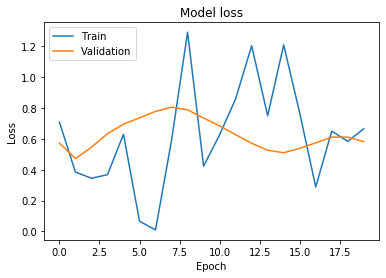

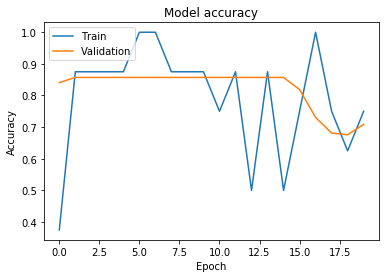

6/6 [==============================] - 0s 2ms/step


In [128]:
verbose, epoch, batch_size = 1, 100, 4
activationFunction='relu'

def VGGNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = VGGNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

vgg_acc_h = accuracy_score(y_pred, y_test)
vgg_roc_h = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
vgg_prec_h = precision_score(y_pred, y_test)
vgg_rec_h = recall_score(y_pred, y_test)
vgg_f1_h = f1_score(y_pred, y_test)
vgg_mcc_h = matthews_corrcoef(y_pred, y_test)
vgg_kap_h = cohen_kappa_score(y_pred, y_test)
vgg_jacc_h = jaccard_score(y_pred, y_test)
vgg_gmea_h = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV - VGGNets',vgg_acc_h,vgg_roc_h,vgg_prec_h,vgg_rec_h,vgg_f1_h,vgg_mcc_h,vgg_kap_h,vgg_jacc_h,vgg_gmea_h)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 599, 128)          384       
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 299, 128)          0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 299, 128)          0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 38272)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 76546     
Total params: 76,930
Trainable params: 76,930
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 269ms/step - loss: 0.6865 - accuracy: 0.6250 - val_loss: 0.667

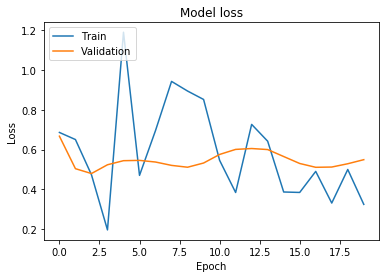

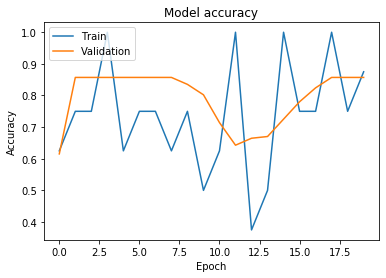

6/6 [==============================] - 0s 997us/step


In [129]:
def ResNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = ResNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

res_acc_h = accuracy_score(y_pred, y_test)
res_roc_h = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
res_prec_h = precision_score(y_pred, y_test)
res_rec_h = recall_score(y_pred, y_test)
res_f1_h = f1_score(y_pred, y_test)
res_mcc_h = matthews_corrcoef(y_pred, y_test)
res_kap_h = cohen_kappa_score(y_pred, y_test)
res_jacc_h = jaccard_score(y_pred, y_test)
res_gmea_h = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV - ResNets',res_acc_h,res_roc_h,res_prec_h,res_rec_h,res_f1_h,res_mcc_h,res_kap_h,res_jacc_h,res_gmea_h)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 599, 128)          384       
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 299, 128)          0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 299, 128)          0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 38272)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 76546     
Total params: 76,930
Trainable params: 76,930
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 155ms/step - loss: 0.5719 - accuracy: 0.5000 - val_loss: 0.472

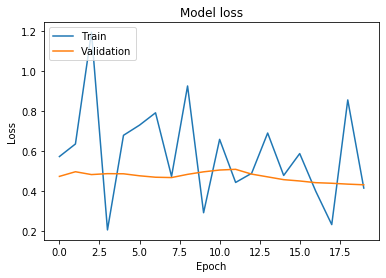

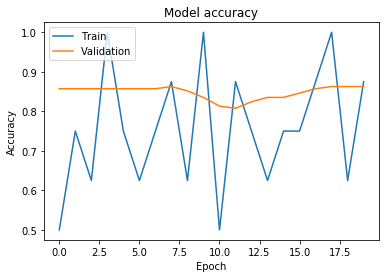

6/6 [==============================] - 0s 797us/step


In [130]:
def DenseNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = DenseNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

dense_acc_h = accuracy_score(y_pred, y_test)
dense_roc_h = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
dense_prec_h = precision_score(y_pred, y_test)
dense_rec_h = recall_score(y_pred, y_test)
dense_f1_h = f1_score(y_pred, y_test)
dense_mcc_h = matthews_corrcoef(y_pred, y_test)
dense_kap_h = cohen_kappa_score(y_pred, y_test)
dense_jacc_h = jaccard_score(y_pred, y_test)
dense_gmea_h = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV - DenseNets',dense_acc_h,dense_roc_h,dense_prec_h,dense_rec_h,dense_f1_h,dense_mcc_h,dense_kap_h,dense_jacc_h,dense_gmea_h)

# EXP-WSI

In [131]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(EXP_WSI, y_multimodal, test_size = 0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((907, 1200), (907,), (161, 1200), (161,))

In [132]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm_acc_i = accuracy_score(y_pred, y_test)
svm_roc_i = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm_prec_i = precision_score(y_pred, y_test)
svm_rec_i = recall_score(y_pred, y_test)
svm_f1_i = f1_score(y_pred, y_test)
svm_mcc_i = matthews_corrcoef(y_pred, y_test)
svm_kap_i = cohen_kappa_score(y_pred, y_test)
svm_jacc_i = jaccard_score(y_pred, y_test)
svm_gmea_i = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-WSI - SVM - rbf',svm_acc_i,svm_roc_i,svm_prec_i,svm_rec_i,svm_f1_i,svm_mcc_i,svm_kap_i,svm_jacc_i,svm_gmea_i)

In [133]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm1_acc_i = accuracy_score(y_pred, y_test)
svm1_roc_i = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm1_prec_i = precision_score(y_pred, y_test)
svm1_rec_i = recall_score(y_pred, y_test)
svm1_f1_i = f1_score(y_pred, y_test)
svm1_mcc_i = matthews_corrcoef(y_pred, y_test)
svm1_kap_i = cohen_kappa_score(y_pred, y_test)
svm1_jacc_i = jaccard_score(y_pred, y_test)
svm1_gmea_i = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-WSI - SVM - Poly',svm1_acc_i,svm1_roc_i,svm1_prec_i,svm1_rec_i,svm1_f1_i,svm1_mcc_i,svm1_kap_i,svm1_jacc_i,svm1_gmea_i)

In [134]:
clf = SVC(C=c,kernel=utility_kernel, probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm2_acc_i = accuracy_score(y_pred, y_test)
svm2_roc_i = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm2_prec_i = precision_score(y_pred, y_test)
svm2_rec_i = recall_score(y_pred, y_test)
svm2_f1_i = f1_score(y_pred, y_test)
svm2_mcc_i = matthews_corrcoef(y_pred, y_test)
svm2_kap_i = cohen_kappa_score(y_pred, y_test)
svm2_jacc_i = jaccard_score(y_pred, y_test)
svm2_gmea_i = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-WSI - SVM - Utility ',svm2_acc_i,svm2_roc_i,svm2_prec_i,svm2_rec_i,svm2_f1_i,svm2_mcc_i,svm2_kap_i,svm2_jacc_i,svm2_gmea_i)

In [135]:
clf = SVC(kernel ='linear', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm3_acc_i = accuracy_score(y_pred, y_test)
svm3_roc_i = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm3_prec_i = precision_score(y_pred, y_test)
svm3_rec_i = recall_score(y_pred, y_test)
svm3_f1_i = f1_score(y_pred, y_test)
svm3_mcc_i = matthews_corrcoef(y_pred, y_test)
svm3_kap_i = cohen_kappa_score(y_pred, y_test)
svm3_jacc_i = jaccard_score(y_pred, y_test)
svm3_gmea_i = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-WSI - SVM - Linear ',svm3_acc_i,svm3_roc_i,svm3_prec_i,svm3_rec_i,svm3_f1_i,svm3_mcc_i,svm3_kap_i,svm3_jacc_i,svm3_gmea_i)

In [136]:
clf = SVC(kernel ='sigmoid', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm4_acc_i = accuracy_score(y_pred, y_test)
svm4_roc_i = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm4_prec_i = precision_score(y_pred, y_test)
svm4_rec_i = recall_score(y_pred, y_test)
svm4_f1_i = f1_score(y_pred, y_test)
svm4_mcc_i = matthews_corrcoef(y_pred, y_test)
svm4_kap_i = cohen_kappa_score(y_pred, y_test)
svm4_jacc_i = jaccard_score(y_pred, y_test)
svm4_gmea_i = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-WSI - SVM - Sigmoid',svm4_acc_i,svm4_roc_i,svm4_prec_i,svm4_rec_i,svm4_f1_i,svm4_mcc_i,svm4_kap_i,svm4_jacc_i,svm4_gmea_i)

In [137]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model 
rf = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

rf_acc_i = accuracy_score(y_pred, y_test)
rf_roc_i = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
rf_prec_i = precision_score(y_pred, y_test)
rf_rec_i = recall_score(y_pred, y_test)
rf_f1_i = f1_score(y_pred, y_test)
rf_mcc_i = matthews_corrcoef(y_pred, y_test)
rf_kap_i = cohen_kappa_score(y_pred, y_test)
rf_jacc_i = jaccard_score(y_pred, y_test)
rf_gmea_i = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-WSI - RF',rf_acc_i,rf_roc_i,rf_prec_i,rf_rec_i,rf_f1_i,rf_mcc_i,rf_kap_i,rf_jacc_i,rf_gmea_i)

In [138]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)

dt_acc_i = accuracy_score(y_pred, y_test)
dt_roc_i = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
dt_prec_i = precision_score(y_pred, y_test)
dt_rec_i = recall_score(y_pred, y_test)
dt_f1_i = f1_score(y_pred, y_test)
dt_mcc_i = matthews_corrcoef(y_pred, y_test)
dt_kap_i = cohen_kappa_score(y_pred, y_test)
dt_jacc_i = jaccard_score(y_pred, y_test)
dt_gmea_i = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-WSI - DT',dt_acc_i,dt_roc_i,dt_prec_i,dt_rec_i,dt_f1_i,dt_mcc_i,dt_kap_i,dt_jacc_i,dt_gmea_i)

In [139]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.pipeline import Pipeline

# instantiate the model
nb=  GaussianNB()

# fit the model 
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
y_prob = nb.predict_proba(X_test)

nb_acc_i = accuracy_score(y_pred, y_test)
nb_roc_i = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
nb_prec_i = precision_score(y_pred, y_test)
nb_rec_i = recall_score(y_pred, y_test)
nb_f1_i = f1_score(y_pred, y_test)
nb_mcc_i = matthews_corrcoef(y_pred, y_test)
nb_kap_i = cohen_kappa_score(y_pred, y_test)
nb_jacc_i = jaccard_score(y_pred, y_test)
nb_gmea_i = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-WSI - NB',nb_acc_i,nb_roc_i,nb_prec_i,nb_rec_i,nb_f1_i,nb_mcc_i,nb_kap_i,nb_jacc_i,nb_gmea_i)

In [140]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2 = SVC(probability=True)
clf3 = DecisionTreeClassifier(max_depth=30)

eclf1 = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train, y_train)

y_pred = eclf1.predict(X_test)
y_prob = eclf1.predict_proba(X_test)

vot_acc_i = accuracy_score(y_pred, y_test)
vot_roc_i = roc_auc_score(y_test, eclf1.predict_proba(X_test)[:, 1])
vot_prec_i = precision_score(y_pred, y_test)
vot_rec_i = recall_score(y_pred, y_test)
vot_f1_i = f1_score(y_pred, y_test)
vot_mcc_i = matthews_corrcoef(y_pred, y_test)
vot_kap_i = cohen_kappa_score(y_pred, y_test)
vot_jacc_i = jaccard_score(y_pred, y_test)
vot_gmea_i = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-WSI - vot',vot_acc_i,vot_roc_i,vot_prec_i,vot_rec_i,vot_f1_i,vot_mcc_i,vot_kap_i,vot_jacc_i,vot_gmea_i)

In [141]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

X_train=X_train
X_test=X_test

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 1199, 128)         384       
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 599, 128)          0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 599, 128)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 76672)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 153346    
Total params: 153,730
Trainable params: 153,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 155ms/step - loss: 11.3562 - accuracy: 0.2500 - val_loss: 13

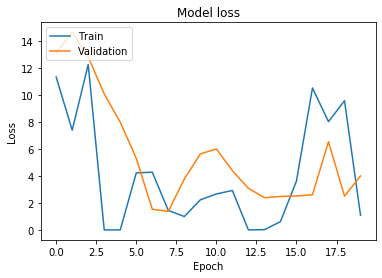

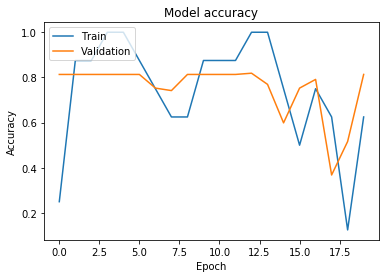

6/6 [==============================] - 0s 1ms/step


In [142]:
verbose, epoch, batch_size = 1, 100, 4
activationFunction='relu'

def VGGNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = VGGNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

vgg_acc_i = accuracy_score(y_pred, y_test)
vgg_roc_i = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
vgg_prec_i = precision_score(y_pred, y_test)
vgg_rec_i = recall_score(y_pred, y_test)
vgg_f1_i = f1_score(y_pred, y_test)
vgg_mcc_i = matthews_corrcoef(y_pred, y_test)
vgg_kap_i = cohen_kappa_score(y_pred, y_test)
vgg_jacc_i = jaccard_score(y_pred, y_test)
vgg_gmea_i = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-WSI - VGGNets',vgg_acc_i,vgg_roc_i,vgg_prec_i,vgg_rec_i,vgg_f1_i,vgg_mcc_i,vgg_kap_i,vgg_jacc_i,vgg_gmea_i)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 1199, 128)         384       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 599, 128)          0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 599, 128)          0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 76672)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 153346    
Total params: 153,730
Trainable params: 153,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 196ms/step - loss: 8.8777 - accuracy: 0.5000 - val_loss: 13.

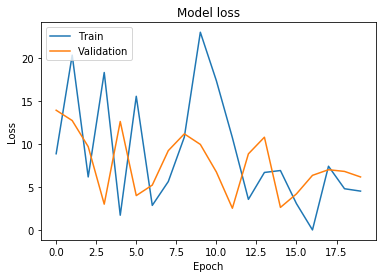

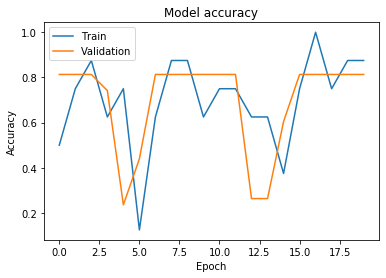

6/6 [==============================] - 0s 997us/step


In [143]:
def ResNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = ResNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

res_acc_i = accuracy_score(y_pred, y_test)
res_roc_i = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
res_prec_i = precision_score(y_pred, y_test)
res_rec_i = recall_score(y_pred, y_test)
res_f1_i = f1_score(y_pred, y_test)
res_mcc_i = matthews_corrcoef(y_pred, y_test)
res_kap_i = cohen_kappa_score(y_pred, y_test)
res_jacc_i = jaccard_score(y_pred, y_test)
res_gmea_i = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-WSI - ResNets',res_acc_i,res_roc_i,res_prec_i,res_rec_i,res_f1_i,res_mcc_i,res_kap_i,res_jacc_i,res_gmea_i)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 1199, 128)         384       
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 599, 128)          0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 599, 128)          0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 76672)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 153346    
Total params: 153,730
Trainable params: 153,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 178ms/step - loss: 3.9428 - accuracy: 0.6250 - val_loss: 12.

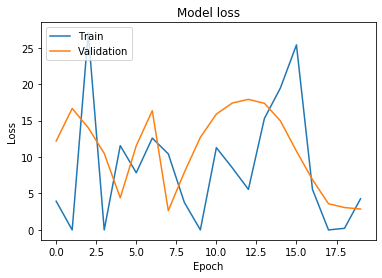

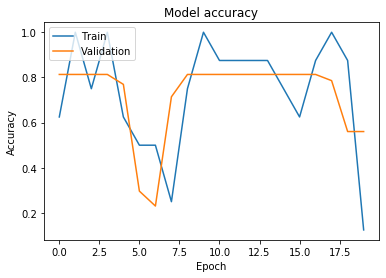

6/6 [==============================] - 0s 997us/step


In [144]:
def DenseNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = DenseNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

dense_acc_i = accuracy_score(y_pred, y_test)
dense_roc_i = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
dense_prec_i = precision_score(y_pred, y_test)
dense_rec_i = recall_score(y_pred, y_test)
dense_f1_i = f1_score(y_pred, y_test)
dense_mcc_i = matthews_corrcoef(y_pred, y_test)
dense_kap_i = cohen_kappa_score(y_pred, y_test)
dense_jacc_i = jaccard_score(y_pred, y_test)
dense_gmea_i = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-WSI - DenseNets',dense_acc_i,dense_roc_i,dense_prec_i,dense_rec_i,dense_f1_i,dense_mcc_i,dense_kap_i,dense_jacc_i,dense_gmea_i)

# CNV-WSI

In [145]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(CNV_WSI, y_multimodal, test_size = 0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((907, 1000), (907,), (161, 1000), (161,))

In [146]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm_acc_j = accuracy_score(y_pred, y_test)
svm_roc_j = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm_prec_j = precision_score(y_pred, y_test)
svm_rec_j = recall_score(y_pred, y_test)
svm_f1_j = f1_score(y_pred, y_test)
svm_mcc_j = matthews_corrcoef(y_pred, y_test)
svm_kap_j = cohen_kappa_score(y_pred, y_test)
svm_jacc_j = jaccard_score(y_pred, y_test)
svm_gmea_j = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-WSI - SVM - rbf',svm_acc_j,svm_roc_j,svm_prec_j,svm_rec_j,svm_f1_j,svm_mcc_j,svm_kap_j,svm_jacc_j,svm_gmea_j)

In [147]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm1_acc_j = accuracy_score(y_pred, y_test)
svm1_roc_j = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm1_prec_j = precision_score(y_pred, y_test)
svm1_rec_j = recall_score(y_pred, y_test)
svm1_f1_j = f1_score(y_pred, y_test)
svm1_mcc_j = matthews_corrcoef(y_pred, y_test)
svm1_kap_j = cohen_kappa_score(y_pred, y_test)
svm1_jacc_j = jaccard_score(y_pred, y_test)
svm1_gmea_j = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-WSI - SVM - Poly',svm1_acc_j,svm1_roc_j,svm1_prec_j,svm1_rec_j,svm1_f1_j,svm1_mcc_j,svm1_kap_j,svm1_jacc_j,svm1_gmea_j)

In [148]:
clf = SVC(C=c,kernel=utility_kernel, probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm2_acc_j = accuracy_score(y_pred, y_test)
svm2_roc_j = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm2_prec_j = precision_score(y_pred, y_test)
svm2_rec_j = recall_score(y_pred, y_test)
svm2_f1_j = f1_score(y_pred, y_test)
svm2_mcc_j = matthews_corrcoef(y_pred, y_test)
svm2_kap_j = cohen_kappa_score(y_pred, y_test)
svm2_jacc_j = jaccard_score(y_pred, y_test)
svm2_gmea_j = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-WSI - SVM - Utility ',svm2_acc_j,svm2_roc_j,svm2_prec_j,svm2_rec_j,svm2_f1_j,svm2_mcc_j,svm2_kap_j,svm2_jacc_j,svm2_gmea_j)

In [149]:
clf = SVC(kernel ='linear', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm3_acc_j = accuracy_score(y_pred, y_test)
svm3_roc_j = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm3_prec_j = precision_score(y_pred, y_test)
svm3_rec_j = recall_score(y_pred, y_test)
svm3_f1_j = f1_score(y_pred, y_test)
svm3_mcc_j = matthews_corrcoef(y_pred, y_test)
svm3_kap_j = cohen_kappa_score(y_pred, y_test)
svm3_jacc_j = jaccard_score(y_pred, y_test)
svm3_gmea_j = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-WSI - SVM - Linear ',svm3_acc_j,svm3_roc_j,svm3_prec_j,svm3_rec_j,svm3_f1_j,svm3_mcc_j,svm3_kap_j,svm3_jacc_j,svm3_gmea_j)

In [150]:
clf = SVC(kernel ='sigmoid', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm4_acc_j = accuracy_score(y_pred, y_test)
svm4_roc_j = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm4_prec_j = precision_score(y_pred, y_test)
svm4_rec_j = recall_score(y_pred, y_test)
svm4_f1_j = f1_score(y_pred, y_test)
svm4_mcc_j = matthews_corrcoef(y_pred, y_test)
svm4_kap_j = cohen_kappa_score(y_pred, y_test)
svm4_jacc_j = jaccard_score(y_pred, y_test)
svm4_gmea_j = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-WSI - SVM - Sigmoid',svm4_acc_j,svm4_roc_j,svm4_prec_j,svm4_rec_j,svm4_f1_j,svm4_mcc_j,svm4_kap_j,svm4_jacc_j,svm4_gmea_j)

In [151]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model 
rf = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

rf_acc_j = accuracy_score(y_pred, y_test)
rf_roc_j = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
rf_prec_j = precision_score(y_pred, y_test)
rf_rec_j = recall_score(y_pred, y_test)
rf_f1_j = f1_score(y_pred, y_test)
rf_mcc_j = matthews_corrcoef(y_pred, y_test)
rf_kap_j = cohen_kappa_score(y_pred, y_test)
rf_jacc_j = jaccard_score(y_pred, y_test)
rf_gmea_j = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-WSI - RF',rf_acc_j,rf_roc_j,rf_prec_j,rf_rec_j,rf_f1_j,rf_mcc_j,rf_kap_j,rf_jacc_j,rf_gmea_j)

In [152]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)

dt_acc_j = accuracy_score(y_pred, y_test)
dt_roc_j = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
dt_prec_j = precision_score(y_pred, y_test)
dt_rec_j = recall_score(y_pred, y_test)
dt_f1_j = f1_score(y_pred, y_test)
dt_mcc_j = matthews_corrcoef(y_pred, y_test)
dt_kap_j = cohen_kappa_score(y_pred, y_test)
dt_jacc_j = jaccard_score(y_pred, y_test)
dt_gmea_j = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-WSI - DT',dt_acc_j,dt_roc_j,dt_prec_j,dt_rec_j,dt_f1_j,dt_mcc_j,dt_kap_j,dt_jacc_j,dt_gmea_j)

In [153]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.pipeline import Pipeline

# instantiate the model
nb=  GaussianNB()

# fit the model 
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
y_prob = nb.predict_proba(X_test)

nb_acc_j = accuracy_score(y_pred, y_test)
nb_roc_j = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
nb_prec_j = precision_score(y_pred, y_test)
nb_rec_j = recall_score(y_pred, y_test)
nb_f1_j = f1_score(y_pred, y_test)
nb_mcc_j = matthews_corrcoef(y_pred, y_test)
nb_kap_j = cohen_kappa_score(y_pred, y_test)
nb_jacc_j = jaccard_score(y_pred, y_test)
nb_gmea_j = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-WSI - NB',nb_acc_j,nb_roc_j,nb_prec_j,nb_rec_j,nb_f1_j,nb_mcc_j,nb_kap_j,nb_jacc_j,nb_gmea_j)

In [154]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2 = SVC(probability=True)
clf3 = DecisionTreeClassifier(max_depth=30)

eclf1 = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train, y_train)

y_pred = eclf1.predict(X_test)
y_prob = eclf1.predict_proba(X_test)

vot_acc_j = accuracy_score(y_pred, y_test)
vot_roc_j = roc_auc_score(y_test, eclf1.predict_proba(X_test)[:, 1])
vot_prec_j = precision_score(y_pred, y_test)
vot_rec_j = recall_score(y_pred, y_test)
vot_f1_j = f1_score(y_pred, y_test)
vot_mcc_j = matthews_corrcoef(y_pred, y_test)
vot_kap_j = cohen_kappa_score(y_pred, y_test)
vot_jacc_j = jaccard_score(y_pred, y_test)
vot_gmea_j = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-WSI - vot',vot_acc_j,vot_roc_j,vot_prec_j,vot_rec_j,vot_f1_j,vot_mcc_j,vot_kap_j,vot_jacc_j,vot_gmea_j)

In [155]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

X_train=X_train
X_test=X_test

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 999, 128)          384       
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 499, 128)          0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 499, 128)          0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 63872)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 127746    
Total params: 128,130
Trainable params: 128,130
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 158ms/step - loss: 19.8128 - accuracy: 0.5000 - val_loss: 10

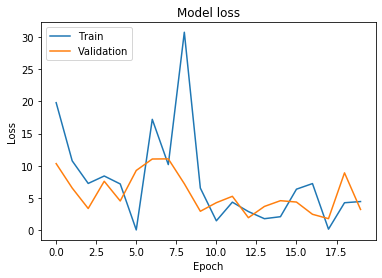

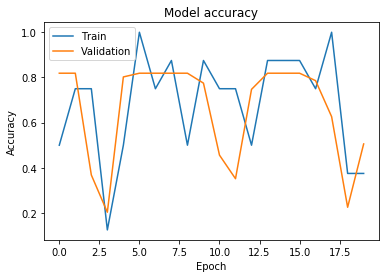

6/6 [==============================] - 0s 997us/step


In [156]:
verbose, epoch, batch_size = 1, 100, 4
activationFunction='relu'

def VGGNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = VGGNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

vgg_acc_j = accuracy_score(y_pred, y_test)
vgg_roc_j = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
vgg_prec_j = precision_score(y_pred, y_test)
vgg_rec_j = recall_score(y_pred, y_test)
vgg_f1_j = f1_score(y_pred, y_test)
vgg_mcc_j = matthews_corrcoef(y_pred, y_test)
vgg_kap_j = cohen_kappa_score(y_pred, y_test)
vgg_jacc_j = jaccard_score(y_pred, y_test)
vgg_gmea_j = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-WSI - VGGNets',vgg_acc_j,vgg_roc_j,vgg_prec_j,vgg_rec_j,vgg_f1_j,vgg_mcc_j,vgg_kap_j,vgg_jacc_j,vgg_gmea_j)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 999, 128)          384       
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 499, 128)          0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 499, 128)          0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 63872)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 127746    
Total params: 128,130
Trainable params: 128,130
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 208ms/step - loss: 8.8029 - accuracy: 0.6250 - val_loss: 12.

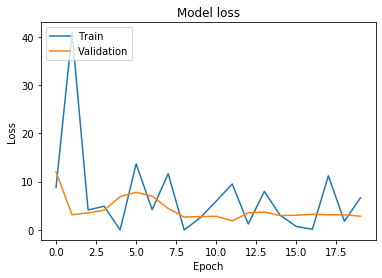

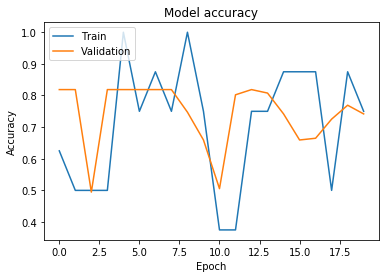

6/6 [==============================] - 0s 997us/step


In [157]:
def ResNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = ResNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

res_acc_j = accuracy_score(y_pred, y_test)
res_roc_j = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
res_prec_j = precision_score(y_pred, y_test)
res_rec_j = recall_score(y_pred, y_test)
res_f1_j = f1_score(y_pred, y_test)
res_mcc_j = matthews_corrcoef(y_pred, y_test)
res_kap_j = cohen_kappa_score(y_pred, y_test)
res_jacc_j = jaccard_score(y_pred, y_test)
res_gmea_j = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV - ResNets',res_acc_j,res_roc_j,res_prec_j,res_rec_j,res_f1_j,res_mcc_j,res_kap_j,res_jacc_j,res_gmea_j)

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 999, 128)          384       
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 499, 128)          0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 499, 128)          0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 63872)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 127746    
Total params: 128,130
Trainable params: 128,130
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 1s 158ms/step - loss: 6.8873 - accuracy: 0.3750 - val_loss: 8.0

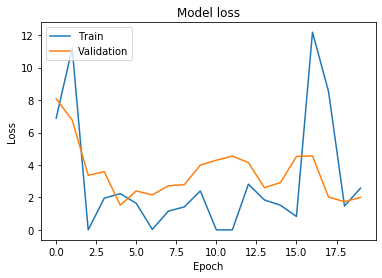

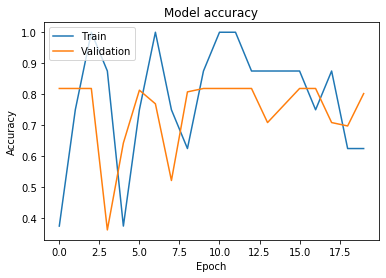

6/6 [==============================] - 0s 1ms/step


In [158]:
def DenseNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = DenseNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

dense_acc_j = accuracy_score(y_pred, y_test)
dense_roc_j = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
dense_prec_j = precision_score(y_pred, y_test)
dense_rec_j = recall_score(y_pred, y_test)
dense_f1_j = f1_score(y_pred, y_test)
dense_mcc_j = matthews_corrcoef(y_pred, y_test)
dense_kap_j = cohen_kappa_score(y_pred, y_test)
dense_jacc_j = jaccard_score(y_pred, y_test)
dense_gmea_j = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV - DenseNets',dense_acc_j,dense_roc_j,dense_prec_j,dense_rec_j,dense_f1_j,dense_mcc_j,dense_kap_j,dense_jacc_j,dense_gmea_j)

# CLN-EXP-CNV

In [159]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(CLN_EXP_CNV, y_multimodal, test_size = 0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((907, 610), (907,), (161, 610), (161,))

In [160]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm_acc_k = accuracy_score(y_pred, y_test)
svm_roc_k = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm_prec_k = precision_score(y_pred, y_test)
svm_rec_k = recall_score(y_pred, y_test)
svm_f1_k = f1_score(y_pred, y_test)
svm_mcc_k = matthews_corrcoef(y_pred, y_test)
svm_kap_k = cohen_kappa_score(y_pred, y_test)
svm_jacc_k = jaccard_score(y_pred, y_test)
svm_gmea_k = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-CNV - SVM - rbf',svm_acc_k,svm_roc_k,svm_prec_k,svm_rec_k,svm_f1_k,svm_mcc_k,svm_kap_k,svm_jacc_k,svm_gmea_k)

In [161]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm1_acc_k = accuracy_score(y_pred, y_test)
svm1_roc_k = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm1_prec_k = precision_score(y_pred, y_test)
svm1_rec_k = recall_score(y_pred, y_test)
svm1_f1_k = f1_score(y_pred, y_test)
svm1_mcc_k = matthews_corrcoef(y_pred, y_test)
svm1_kap_k = cohen_kappa_score(y_pred, y_test)
svm1_jacc_k = jaccard_score(y_pred, y_test)
svm1_gmea_k = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-CNV - SVM - Poly',svm1_acc_k,svm1_roc_k,svm1_prec_k,svm1_rec_k,svm1_f1_k,svm1_mcc_k,svm1_kap_k,svm1_jacc_k,svm1_gmea_k)

In [162]:
clf = SVC(C=c,kernel=utility_kernel, probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm2_acc_k = accuracy_score(y_pred, y_test)
svm2_roc_k = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm2_prec_k = precision_score(y_pred, y_test)
svm2_rec_k = recall_score(y_pred, y_test)
svm2_f1_k = f1_score(y_pred, y_test)
svm2_mcc_k = matthews_corrcoef(y_pred, y_test)
svm2_kap_k = cohen_kappa_score(y_pred, y_test)
svm2_jacc_k = jaccard_score(y_pred, y_test)
svm2_gmea_k = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-CNV - SVM - Utility ',svm2_acc_k,svm2_roc_k,svm2_prec_k,svm2_rec_k,svm2_f1_k,svm2_mcc_k,svm2_kap_k,svm2_jacc_k,svm2_gmea_k)

In [163]:
clf = SVC(kernel ='linear', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm3_acc_k = accuracy_score(y_pred, y_test)
svm3_roc_k = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm3_prec_k = precision_score(y_pred, y_test)
svm3_rec_k = recall_score(y_pred, y_test)
svm3_f1_k = f1_score(y_pred, y_test)
svm3_mcc_k = matthews_corrcoef(y_pred, y_test)
svm3_kap_k = cohen_kappa_score(y_pred, y_test)
svm3_jacc_k = jaccard_score(y_pred, y_test)
svm3_gmea_k = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-CNV - SVM - Linear ',svm3_acc_k,svm3_roc_k,svm3_prec_k,svm3_rec_k,svm3_f1_k,svm3_mcc_k,svm3_kap_k,svm3_jacc_k,svm3_gmea_k)

In [164]:
clf = SVC(kernel ='sigmoid', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm4_acc_k = accuracy_score(y_pred, y_test)
svm4_roc_k = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm4_prec_k = precision_score(y_pred, y_test)
svm4_rec_k = recall_score(y_pred, y_test)
svm4_f1_k = f1_score(y_pred, y_test)
svm4_mcc_k = matthews_corrcoef(y_pred, y_test)
svm4_kap_k = cohen_kappa_score(y_pred, y_test)
svm4_jacc_k = jaccard_score(y_pred, y_test)
svm4_gmea_k = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-CNV - SVM - Sigmoid',svm4_acc_k,svm4_roc_k,svm4_prec_k,svm4_rec_k,svm4_f1_k,svm4_mcc_k,svm4_kap_k,svm4_jacc_k,svm4_gmea_k)

In [165]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model 
rf = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

rf_acc_k = accuracy_score(y_pred, y_test)
rf_roc_k = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
rf_prec_k = precision_score(y_pred, y_test)
rf_rec_k = recall_score(y_pred, y_test)
rf_f1_k = f1_score(y_pred, y_test)
rf_mcc_k = matthews_corrcoef(y_pred, y_test)
rf_kap_k = cohen_kappa_score(y_pred, y_test)
rf_jacc_k = jaccard_score(y_pred, y_test)
rf_gmea_k = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-CNV - RF',rf_acc_k,rf_roc_k,rf_prec_k,rf_rec_k,rf_f1_k,rf_mcc_k,rf_kap_k,rf_jacc_k,rf_gmea_k)

In [166]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)

dt_acc_k = accuracy_score(y_pred, y_test)
dt_roc_k = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
dt_prec_k = precision_score(y_pred, y_test)
dt_rec_k = recall_score(y_pred, y_test)
dt_f1_k = f1_score(y_pred, y_test)
dt_mcc_k = matthews_corrcoef(y_pred, y_test)
dt_kap_k = cohen_kappa_score(y_pred, y_test)
dt_jacc_k = jaccard_score(y_pred, y_test)
dt_gmea_k = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-CNV - DT',dt_acc_k,dt_roc_k,dt_prec_k,dt_rec_k,dt_f1_k,dt_mcc_k,dt_kap_k,dt_jacc_k,dt_gmea_k)

In [167]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.pipeline import Pipeline

# instantiate the model
nb=  GaussianNB()

# fit the model 
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
y_prob = nb.predict_proba(X_test)

nb_acc_k = accuracy_score(y_pred, y_test)
nb_roc_k = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
nb_prec_k = precision_score(y_pred, y_test)
nb_rec_k = recall_score(y_pred, y_test)
nb_f1_k = f1_score(y_pred, y_test)
nb_mcc_k = matthews_corrcoef(y_pred, y_test)
nb_kap_k = cohen_kappa_score(y_pred, y_test)
nb_jacc_k = jaccard_score(y_pred, y_test)
nb_gmea_k = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-CNV - NB',nb_acc_k,nb_roc_k,nb_prec_k,nb_rec_k,nb_f1_k,nb_mcc_k,nb_kap_k,nb_jacc_k,nb_gmea_k)

In [168]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2 = SVC(probability=True)
clf3 = DecisionTreeClassifier(max_depth=30)

eclf1 = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train, y_train)

y_pred = eclf1.predict(X_test)
y_prob = eclf1.predict_proba(X_test)

vot_acc_k = accuracy_score(y_pred, y_test)
vot_roc_k = roc_auc_score(y_test, eclf1.predict_proba(X_test)[:, 1])
vot_prec_k = precision_score(y_pred, y_test)
vot_rec_k = recall_score(y_pred, y_test)
vot_f1_k = f1_score(y_pred, y_test)
vot_mcc_k = matthews_corrcoef(y_pred, y_test)
vot_kap_k = cohen_kappa_score(y_pred, y_test)
vot_jacc_k = jaccard_score(y_pred, y_test)
vot_gmea_k = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-CNV - vot',vot_acc_k,vot_roc_k,vot_prec_k,vot_rec_k,vot_f1_k,vot_mcc_k,vot_kap_k,vot_jacc_k,vot_gmea_k)

In [169]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

X_train=X_train
X_test=X_test

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 609, 128)          384       
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 304, 128)          0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 304, 128)          0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 38912)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 77826     
Total params: 78,210
Trainable params: 78,210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 1s 278ms/step - loss: 0.7705 - accuracy: 0.2500 - val_loss: 0.600

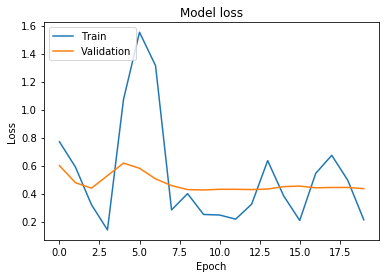

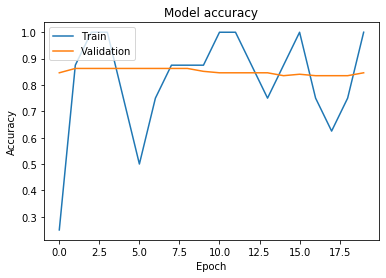

6/6 [==============================] - 0s 2ms/step


In [170]:
verbose, epoch, batch_size = 1, 100, 4
activationFunction='relu'

def VGGNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = VGGNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

vgg_acc_k = accuracy_score(y_pred, y_test)
vgg_roc_k = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
vgg_prec_k = precision_score(y_pred, y_test)
vgg_rec_k = recall_score(y_pred, y_test)
vgg_f1_k = f1_score(y_pred, y_test)
vgg_mcc_k = matthews_corrcoef(y_pred, y_test)
vgg_kap_k = cohen_kappa_score(y_pred, y_test)
vgg_jacc_k = jaccard_score(y_pred, y_test)
vgg_gmea_k = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-CNV - VGGNets',vgg_acc_k,vgg_roc_k,vgg_prec_k,vgg_rec_k,vgg_f1_k,vgg_mcc_k,vgg_kap_k,vgg_jacc_k,vgg_gmea_k)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 609, 128)          384       
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 304, 128)          0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 304, 128)          0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 38912)             0         
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 77826     
Total params: 78,210
Trainable params: 78,210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 258ms/step - loss: 0.6494 - accuracy: 0.5000 - val_loss: 0.458

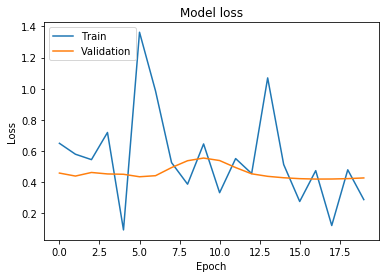

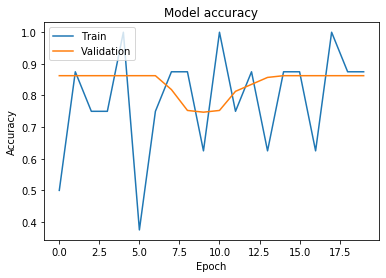

6/6 [==============================] - 0s 997us/step


In [171]:
def ResNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = ResNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

res_acc_k = accuracy_score(y_pred, y_test)
res_roc_k = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
res_prec_k = precision_score(y_pred, y_test)
res_rec_k = recall_score(y_pred, y_test)
res_f1_k = f1_score(y_pred, y_test)
res_mcc_k = matthews_corrcoef(y_pred, y_test)
res_kap_k = cohen_kappa_score(y_pred, y_test)
res_jacc_k = jaccard_score(y_pred, y_test)
res_gmea_k = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-CNV - ResNets',res_acc_k,res_roc_k,res_prec_k,res_rec_k,res_f1_k,res_mcc_k,res_kap_k,res_jacc_k,res_gmea_k)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 609, 128)          384       
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 304, 128)          0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 304, 128)          0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 38912)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 77826     
Total params: 78,210
Trainable params: 78,210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 150ms/step - loss: 0.6691 - accuracy: 0.6250 - val_loss: 0.514

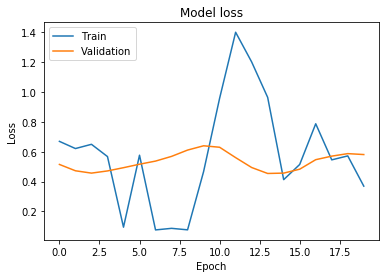

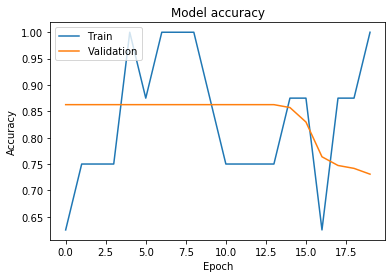

6/6 [==============================] - 0s 997us/step


In [172]:
def DenseNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = DenseNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

dense_acc_k = accuracy_score(y_pred, y_test)
dense_roc_k = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
dense_prec_k = precision_score(y_pred, y_test)
dense_rec_k = recall_score(y_pred, y_test)
dense_f1_k = f1_score(y_pred, y_test)
dense_mcc_k = matthews_corrcoef(y_pred, y_test)
dense_kap_k = cohen_kappa_score(y_pred, y_test)
dense_jacc_k = jaccard_score(y_pred, y_test)
dense_gmea_k = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-CNV - DenseNets',dense_acc_k,dense_roc_k,dense_prec_k,dense_rec_k,dense_f1_k,dense_mcc_k,dense_kap_k,dense_jacc_k,dense_gmea_k)

# CLN-EXP-WSI

In [173]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(CLN_EXP_WSI, y_multimodal, test_size = 0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((907, 1210), (907,), (161, 1210), (161,))

In [174]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm_acc_l = accuracy_score(y_pred, y_test)
svm_roc_l = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm_prec_l = precision_score(y_pred, y_test)
svm_rec_l = recall_score(y_pred, y_test)
svm_f1_l = f1_score(y_pred, y_test)
svm_mcc_l = matthews_corrcoef(y_pred, y_test)
svm_kap_l = cohen_kappa_score(y_pred, y_test)
svm_jacc_l = jaccard_score(y_pred, y_test)
svm_gmea_l = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-WSI - SVM - rbf',svm_acc_l,svm_roc_l,svm_prec_l,svm_rec_l,svm_f1_l,svm_mcc_l,svm_kap_l,svm_jacc_l,svm_gmea_l)

In [175]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm1_acc_l = accuracy_score(y_pred, y_test)
svm1_roc_l = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm1_prec_l = precision_score(y_pred, y_test)
svm1_rec_l = recall_score(y_pred, y_test)
svm1_f1_l = f1_score(y_pred, y_test)
svm1_mcc_l = matthews_corrcoef(y_pred, y_test)
svm1_kap_l = cohen_kappa_score(y_pred, y_test)
svm1_jacc_l = jaccard_score(y_pred, y_test)
svm1_gmea_l = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-WSI - SVM - Poly',svm1_acc_l,svm1_roc_l,svm1_prec_l,svm1_rec_l,svm1_f1_l,svm1_mcc_l,svm1_kap_l,svm1_jacc_l,svm1_gmea_l)

In [176]:
clf = SVC(C=c,kernel=utility_kernel, probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm2_acc_l = accuracy_score(y_pred, y_test)
svm2_roc_l = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm2_prec_l = precision_score(y_pred, y_test)
svm2_rec_l = recall_score(y_pred, y_test)
svm2_f1_l = f1_score(y_pred, y_test)
svm2_mcc_l = matthews_corrcoef(y_pred, y_test)
svm2_kap_l = cohen_kappa_score(y_pred, y_test)
svm2_jacc_l = jaccard_score(y_pred, y_test)
svm2_gmea_l = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-WSI - SVM - Utility ',svm2_acc_l,svm2_roc_l,svm2_prec_l,svm2_rec_l,svm2_f1_l,svm2_mcc_l,svm2_kap_l,svm2_jacc_l,svm2_gmea_l)

In [177]:
clf = SVC(kernel ='linear', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm3_acc_l = accuracy_score(y_pred, y_test)
svm3_roc_l = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm3_prec_l = precision_score(y_pred, y_test)
svm3_rec_l = recall_score(y_pred, y_test)
svm3_f1_l = f1_score(y_pred, y_test)
svm3_mcc_l = matthews_corrcoef(y_pred, y_test)
svm3_kap_l = cohen_kappa_score(y_pred, y_test)
svm3_jacc_l = jaccard_score(y_pred, y_test)
svm3_gmea_l = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-WSI - SVM - Linear ',svm3_acc_l,svm3_roc_l,svm3_prec_l,svm3_rec_l,svm3_f1_l,svm3_mcc_l,svm3_kap_l,svm3_jacc_l,svm3_gmea_l)

In [178]:
clf = SVC(kernel ='sigmoid', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm4_acc_l = accuracy_score(y_pred, y_test)
svm4_roc_l = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm4_prec_l = precision_score(y_pred, y_test)
svm4_rec_l = recall_score(y_pred, y_test)
svm4_f1_l = f1_score(y_pred, y_test)
svm4_mcc_l = matthews_corrcoef(y_pred, y_test)
svm4_kap_l = cohen_kappa_score(y_pred, y_test)
svm4_jacc_l = jaccard_score(y_pred, y_test)
svm4_gmea_l = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-WSI - SVM - Sigmoid',svm4_acc_l,svm4_roc_l,svm4_prec_l,svm4_rec_l,svm4_f1_l,svm4_mcc_l,svm4_kap_l,svm4_jacc_l,svm4_gmea_l)

In [179]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model 
rf = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

rf_acc_l = accuracy_score(y_pred, y_test)
rf_roc_l = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
rf_prec_l = precision_score(y_pred, y_test)
rf_rec_l = recall_score(y_pred, y_test)
rf_f1_l = f1_score(y_pred, y_test)
rf_mcc_l = matthews_corrcoef(y_pred, y_test)
rf_kap_l = cohen_kappa_score(y_pred, y_test)
rf_jacc_l = jaccard_score(y_pred, y_test)
rf_gmea_l = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-WSI - RF',rf_acc_l,rf_roc_l,rf_prec_l,rf_rec_l,rf_f1_l,rf_mcc_l,rf_kap_l,rf_jacc_l,rf_gmea_l)

In [180]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)

dt_acc_l = accuracy_score(y_pred, y_test)
dt_roc_l = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
dt_prec_l = precision_score(y_pred, y_test)
dt_rec_l = recall_score(y_pred, y_test)
dt_f1_l = f1_score(y_pred, y_test)
dt_mcc_l = matthews_corrcoef(y_pred, y_test)
dt_kap_l = cohen_kappa_score(y_pred, y_test)
dt_jacc_l = jaccard_score(y_pred, y_test)
dt_gmea_l = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-WSI - DT',dt_acc_l,dt_roc_l,dt_prec_l,dt_rec_l,dt_f1_l,dt_mcc_l,dt_kap_l,dt_jacc_l,dt_gmea_l)

In [181]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.pipeline import Pipeline

# instantiate the model
nb=  GaussianNB()

# fit the model 
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
y_prob = nb.predict_proba(X_test)

nb_acc_l = accuracy_score(y_pred, y_test)
nb_roc_l = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
nb_prec_l = precision_score(y_pred, y_test)
nb_rec_l = recall_score(y_pred, y_test)
nb_f1_l = f1_score(y_pred, y_test)
nb_mcc_l = matthews_corrcoef(y_pred, y_test)
nb_kap_l = cohen_kappa_score(y_pred, y_test)
nb_jacc_l = jaccard_score(y_pred, y_test)
nb_gmea_l = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-WSI - NB',nb_acc_l,nb_roc_l,nb_prec_l,nb_rec_l,nb_f1_l,nb_mcc_l,nb_kap_l,nb_jacc_l,nb_gmea_l)

In [182]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2 = SVC(probability=True)
clf3 = DecisionTreeClassifier(max_depth=30)

eclf1 = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train, y_train)

y_pred = eclf1.predict(X_test)
y_prob = eclf1.predict_proba(X_test)

vot_acc_l = accuracy_score(y_pred, y_test)
vot_roc_l = roc_auc_score(y_test, eclf1.predict_proba(X_test)[:, 1])
vot_prec_l = precision_score(y_pred, y_test)
vot_rec_l = recall_score(y_pred, y_test)
vot_f1_l = f1_score(y_pred, y_test)
vot_mcc_l = matthews_corrcoef(y_pred, y_test)
vot_kap_l = cohen_kappa_score(y_pred, y_test)
vot_jacc_l = jaccard_score(y_pred, y_test)
vot_gmea_l = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-WSI - vot',vot_acc_l,vot_roc_l,vot_prec_l,vot_rec_l,vot_f1_l,vot_mcc_l,vot_kap_l,vot_jacc_l,vot_gmea_l)

In [183]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

X_train=X_train
X_test=X_test

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 1209, 128)         384       
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 604, 128)          0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 604, 128)          0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 77312)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 154626    
Total params: 155,010
Trainable params: 155,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 1s 295ms/step - loss: 5.3966 - accuracy: 0.5000 - val_loss: 3.3

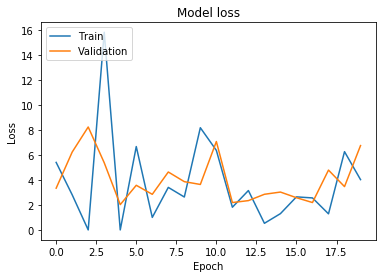

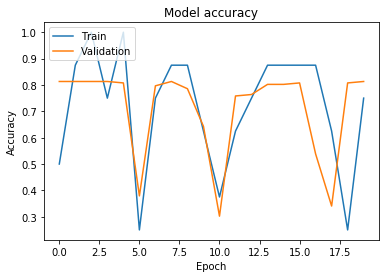

6/6 [==============================] - 0s 997us/step


In [184]:
verbose, epoch, batch_size = 1, 100, 4
activationFunction='relu'

def VGGNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = VGGNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

vgg_acc_l = accuracy_score(y_pred, y_test)
vgg_roc_l = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
vgg_prec_l = precision_score(y_pred, y_test)
vgg_rec_l = recall_score(y_pred, y_test)
vgg_f1_l = f1_score(y_pred, y_test)
vgg_mcc_l = matthews_corrcoef(y_pred, y_test)
vgg_kap_l = cohen_kappa_score(y_pred, y_test)
vgg_jacc_l = jaccard_score(y_pred, y_test)
vgg_gmea_l = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-WSI - VGGNets',vgg_acc_l,vgg_roc_l,vgg_prec_l,vgg_rec_l,vgg_f1_l,vgg_mcc_l,vgg_kap_l,vgg_jacc_l,vgg_gmea_l)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 1209, 128)         384       
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 604, 128)          0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 604, 128)          0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 77312)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 154626    
Total params: 155,010
Trainable params: 155,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 151ms/step - loss: 0.1490 - accuracy: 1.0000 - val_loss: 7.7

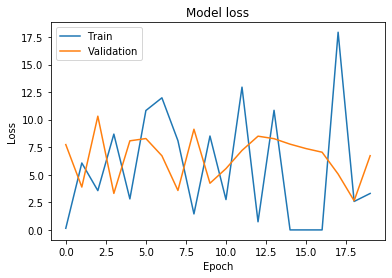

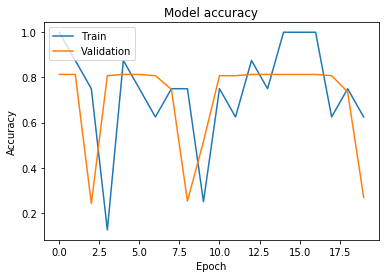

6/6 [==============================] - 0s 997us/step


In [185]:
def ResNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = ResNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

res_acc_l = accuracy_score(y_pred, y_test)
res_roc_l = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
res_prec_l = precision_score(y_pred, y_test)
res_rec_l = recall_score(y_pred, y_test)
res_f1_l = f1_score(y_pred, y_test)
res_mcc_l = matthews_corrcoef(y_pred, y_test)
res_kap_l = cohen_kappa_score(y_pred, y_test)
res_jacc_l = jaccard_score(y_pred, y_test)
res_gmea_l = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-WSI - ResNets',res_acc_l,res_roc_l,res_prec_l,res_rec_l,res_f1_l,res_mcc_l,res_kap_l,res_jacc_l,res_gmea_l)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 1209, 128)         384       
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 604, 128)          0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 604, 128)          0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 77312)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 154626    
Total params: 155,010
Trainable params: 155,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 155ms/step - loss: 8.5771 - accuracy: 0.7500 - val_loss: 13.

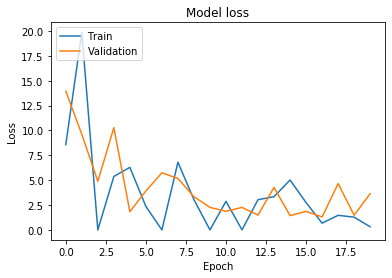

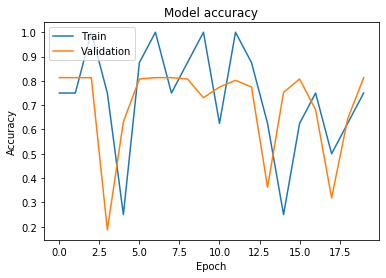

6/6 [==============================] - 0s 997us/step


In [186]:
def DenseNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = DenseNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

dense_acc_l = accuracy_score(y_pred, y_test)
dense_roc_l = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
dense_prec_l = precision_score(y_pred, y_test)
dense_rec_l = recall_score(y_pred, y_test)
dense_f1_l = f1_score(y_pred, y_test)
dense_mcc_l = matthews_corrcoef(y_pred, y_test)
dense_kap_l = cohen_kappa_score(y_pred, y_test)
dense_jacc_l = jaccard_score(y_pred, y_test)
dense_gmea_l = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-EXP-WSI - DenseNets',dense_acc_l,dense_roc_l,dense_prec_l,dense_rec_l,dense_f1_l,dense_mcc_l,dense_kap_l,dense_jacc_l,dense_gmea_l)

# EXP-CNV-WSI

In [187]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(EXP_CNV_WSI, y_multimodal, test_size = 0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((907, 1400), (907,), (161, 1400), (161,))

In [188]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm_acc_m = accuracy_score(y_pred, y_test)
svm_roc_m = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm_prec_m = precision_score(y_pred, y_test)
svm_rec_m = recall_score(y_pred, y_test)
svm_f1_m = f1_score(y_pred, y_test)
svm_mcc_m = matthews_corrcoef(y_pred, y_test)
svm_kap_m = cohen_kappa_score(y_pred, y_test)
svm_jacc_m = jaccard_score(y_pred, y_test)
svm_gmea_m = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV-WSI - SVM - rbf',svm_acc_m,svm_roc_m,svm_prec_m,svm_rec_m,svm_f1_m,svm_mcc_m,svm_kap_m,svm_jacc_m,svm_gmea_m)

In [189]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm1_acc_m = accuracy_score(y_pred, y_test)
svm1_roc_m = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm1_prec_m = precision_score(y_pred, y_test)
svm1_rec_m = recall_score(y_pred, y_test)
svm1_f1_m = f1_score(y_pred, y_test)
svm1_mcc_m = matthews_corrcoef(y_pred, y_test)
svm1_kap_m = cohen_kappa_score(y_pred, y_test)
svm1_jacc_m = jaccard_score(y_pred, y_test)
svm1_gmea_m = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV-WSI - SVM - Poly',svm1_acc_m,svm1_roc_m,svm1_prec_m,svm1_rec_m,svm1_f1_m,svm1_mcc_m,svm1_kap_m,svm1_jacc_m,svm1_gmea_m)

In [190]:
clf = SVC(C=c,kernel=utility_kernel, probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm2_acc_m = accuracy_score(y_pred, y_test)
svm2_roc_m = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm2_prec_m = precision_score(y_pred, y_test)
svm2_rec_m = recall_score(y_pred, y_test)
svm2_f1_m = f1_score(y_pred, y_test)
svm2_mcc_m = matthews_corrcoef(y_pred, y_test)
svm2_kap_m = cohen_kappa_score(y_pred, y_test)
svm2_jacc_m = jaccard_score(y_pred, y_test)
svm2_gmea_m = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV-WSI - SVM - Utility ',svm2_acc_m,svm2_roc_m,svm2_prec_m,svm2_rec_m,svm2_f1_m,svm2_mcc_m,svm2_kap_m,svm2_jacc_m,svm2_gmea_m)

In [191]:
clf = SVC(kernel ='linear', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm3_acc_m = accuracy_score(y_pred, y_test)
svm3_roc_m = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm3_prec_m = precision_score(y_pred, y_test)
svm3_rec_m = recall_score(y_pred, y_test)
svm3_f1_m = f1_score(y_pred, y_test)
svm3_mcc_m = matthews_corrcoef(y_pred, y_test)
svm3_kap_m = cohen_kappa_score(y_pred, y_test)
svm3_jacc_m = jaccard_score(y_pred, y_test)
svm3_gmea_m = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV-WSI - SVM - Linear ',svm3_acc_m,svm3_roc_m,svm3_prec_m,svm3_rec_m,svm3_f1_m,svm3_mcc_m,svm3_kap_m,svm3_jacc_m,svm3_gmea_m)

In [192]:
clf = SVC(kernel ='sigmoid', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm4_acc_m = accuracy_score(y_pred, y_test)
svm4_roc_m = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm4_prec_m = precision_score(y_pred, y_test)
svm4_rec_m = recall_score(y_pred, y_test)
svm4_f1_m = f1_score(y_pred, y_test)
svm4_mcc_m = matthews_corrcoef(y_pred, y_test)
svm4_kap_m = cohen_kappa_score(y_pred, y_test)
svm4_jacc_m = jaccard_score(y_pred, y_test)
svm4_gmea_m = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV-WSI - SVM - Sigmoid',svm4_acc_m,svm4_roc_m,svm4_prec_m,svm4_rec_m,svm4_f1_m,svm4_mcc_m,svm4_kap_m,svm4_jacc_m,svm4_gmea_m)

In [193]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model 
rf = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

rf_acc_m = accuracy_score(y_pred, y_test)
rf_roc_m = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
rf_prec_m = precision_score(y_pred, y_test)
rf_rec_m = recall_score(y_pred, y_test)
rf_f1_m = f1_score(y_pred, y_test)
rf_mcc_m = matthews_corrcoef(y_pred, y_test)
rf_kap_m = cohen_kappa_score(y_pred, y_test)
rf_jacc_m = jaccard_score(y_pred, y_test)
rf_gmea_m = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV-WSI - RF',rf_acc_m,rf_roc_m,rf_prec_m,rf_rec_m,rf_f1_m,rf_mcc_m,rf_kap_m,rf_jacc_m,rf_gmea_m)

In [194]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)

dt_acc_m = accuracy_score(y_pred, y_test)
dt_roc_m = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
dt_prec_m = precision_score(y_pred, y_test)
dt_rec_m = recall_score(y_pred, y_test)
dt_f1_m = f1_score(y_pred, y_test)
dt_mcc_m = matthews_corrcoef(y_pred, y_test)
dt_kap_m = cohen_kappa_score(y_pred, y_test)
dt_jacc_m = jaccard_score(y_pred, y_test)
dt_gmea_m = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV-WSI - DT',dt_acc_m,dt_roc_m,dt_prec_m,dt_rec_m,dt_f1_m,dt_mcc_m,dt_kap_m,dt_jacc_m,dt_gmea_m)

In [195]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.pipeline import Pipeline

# instantiate the model
nb=  GaussianNB()

# fit the model 
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
y_prob = nb.predict_proba(X_test)

nb_acc_m = accuracy_score(y_pred, y_test)
nb_roc_m = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
nb_prec_m = precision_score(y_pred, y_test)
nb_rec_m = recall_score(y_pred, y_test)
nb_f1_m = f1_score(y_pred, y_test)
nb_mcc_m = matthews_corrcoef(y_pred, y_test)
nb_kap_m = cohen_kappa_score(y_pred, y_test)
nb_jacc_m = jaccard_score(y_pred, y_test)
nb_gmea_m = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV-WSI - NB',nb_acc_m,nb_roc_m,nb_prec_m,nb_rec_m,nb_f1_m,nb_mcc_m,nb_kap_m,nb_jacc_m,nb_gmea_m)

In [196]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2 = SVC(probability=True)
clf3 = DecisionTreeClassifier(max_depth=30)

eclf1 = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train, y_train)

y_pred = eclf1.predict(X_test)
y_prob = eclf1.predict_proba(X_test)

vot_acc_m = accuracy_score(y_pred, y_test)
vot_roc_m = roc_auc_score(y_test, eclf1.predict_proba(X_test)[:, 1])
vot_prec_m = precision_score(y_pred, y_test)
vot_rec_m = recall_score(y_pred, y_test)
vot_f1_m = f1_score(y_pred, y_test)
vot_mcc_m = matthews_corrcoef(y_pred, y_test)
vot_kap_m = cohen_kappa_score(y_pred, y_test)
vot_jacc_m = jaccard_score(y_pred, y_test)
vot_gmea_m = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV-WSI - vot',vot_acc_m,vot_roc_m,vot_prec_m,vot_rec_m,vot_f1_m,vot_mcc_m,vot_kap_m,vot_jacc_m,vot_gmea_m)

In [197]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

X_train=X_train
X_test=X_test

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 1399, 128)         384       
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 699, 128)          0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 699, 128)          0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 89472)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 178946    
Total params: 179,330
Trainable params: 179,330
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 160ms/step - loss: 2.3799 - accuracy: 0.8750 - val_loss: 3.3

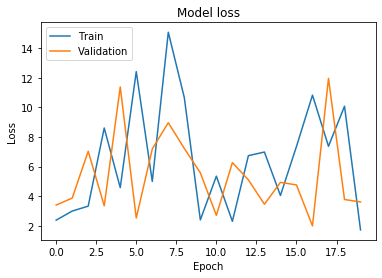

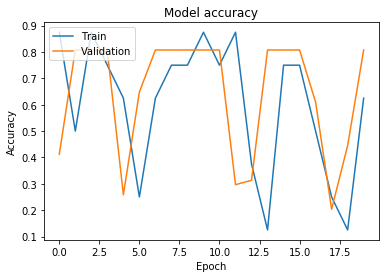

6/6 [==============================] - 0s 997us/step


In [198]:
verbose, epoch, batch_size = 1, 100, 4
activationFunction='relu'

def VGGNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = VGGNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

vgg_acc_m = accuracy_score(y_pred, y_test)
vgg_roc_m = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
vgg_prec_m = precision_score(y_pred, y_test)
vgg_rec_m = recall_score(y_pred, y_test)
vgg_f1_m = f1_score(y_pred, y_test)
vgg_mcc_m = matthews_corrcoef(y_pred, y_test)
vgg_kap_m = cohen_kappa_score(y_pred, y_test)
vgg_jacc_m = jaccard_score(y_pred, y_test)
vgg_gmea_m = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV-WSI - VGGNets',vgg_acc_m,vgg_roc_m,vgg_prec_m,vgg_rec_m,vgg_f1_m,vgg_mcc_m,vgg_kap_m,vgg_jacc_m,vgg_gmea_m)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 1399, 128)         384       
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 699, 128)          0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 699, 128)          0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 89472)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 178946    
Total params: 179,330
Trainable params: 179,330
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 150ms/step - loss: 1.2227 - accuracy: 0.6250 - val_loss: 19.

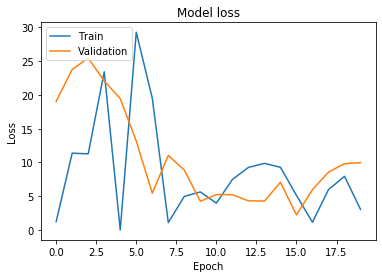

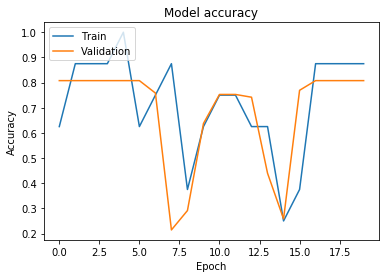

6/6 [==============================] - 0s 997us/step


In [199]:
def ResNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = ResNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

res_acc_m = accuracy_score(y_pred, y_test)
res_roc_m = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
res_prec_m = precision_score(y_pred, y_test)
res_rec_m = recall_score(y_pred, y_test)
res_f1_m = f1_score(y_pred, y_test)
res_mcc_m = matthews_corrcoef(y_pred, y_test)
res_kap_m = cohen_kappa_score(y_pred, y_test)
res_jacc_m = jaccard_score(y_pred, y_test)
res_gmea_m = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV-WSI - ResNets',res_acc_m,res_roc_m,res_prec_m,res_rec_m,res_f1_m,res_mcc_m,res_kap_m,res_jacc_m,res_gmea_m)

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 1399, 128)         384       
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 699, 128)          0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 699, 128)          0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 89472)             0         
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 178946    
Total params: 179,330
Trainable params: 179,330
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 154ms/step - loss: 0.3612 - accuracy: 0.7500 - val_loss: 7.2

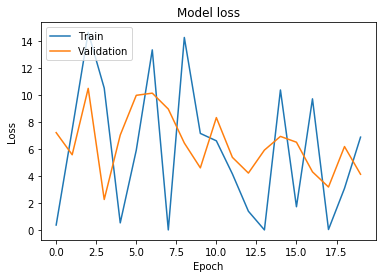

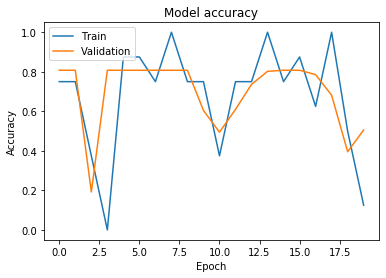

6/6 [==============================] - 0s 1ms/step


In [200]:
def DenseNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = DenseNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

dense_acc_m = accuracy_score(y_pred, y_test)
dense_roc_m = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
dense_prec_m = precision_score(y_pred, y_test)
dense_rec_m = recall_score(y_pred, y_test)
dense_f1_m = f1_score(y_pred, y_test)
dense_mcc_m = matthews_corrcoef(y_pred, y_test)
dense_kap_m = cohen_kappa_score(y_pred, y_test)
dense_jacc_m = jaccard_score(y_pred, y_test)
dense_gmea_m = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('EXP-CNV-WSI - DenseNets',dense_acc_m,dense_roc_m,dense_prec_m,dense_rec_m,dense_f1_m,dense_mcc_m,dense_kap_m,dense_jacc_m,dense_gmea_m)

# CNV-CLN-WSI

In [201]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(CNV_CLN_WSI, y_multimodal, test_size = 0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((907, 1010), (907,), (161, 1010), (161,))

In [202]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm_acc_n = accuracy_score(y_pred, y_test)
svm_roc_n = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm_prec_n = precision_score(y_pred, y_test)
svm_rec_n = recall_score(y_pred, y_test)
svm_f1_n = f1_score(y_pred, y_test)
svm_mcc_n = matthews_corrcoef(y_pred, y_test)
svm_kap_n = cohen_kappa_score(y_pred, y_test)
svm_jacc_n = jaccard_score(y_pred, y_test)
svm_gmea_n = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-CLN-WSI - SVM - rbf',svm_acc_n,svm_roc_n,svm_prec_n,svm_rec_n,svm_f1_n,svm_mcc_n,svm_kap_n,svm_jacc_n,svm_gmea_n)

In [203]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm1_acc_n = accuracy_score(y_pred, y_test)
svm1_roc_n = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm1_prec_n = precision_score(y_pred, y_test)
svm1_rec_n = recall_score(y_pred, y_test)
svm1_f1_n = f1_score(y_pred, y_test)
svm1_mcc_n = matthews_corrcoef(y_pred, y_test)
svm1_kap_n = cohen_kappa_score(y_pred, y_test)
svm1_jacc_n = jaccard_score(y_pred, y_test)
svm1_gmea_n = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-CLN-WSI - SVM - Poly',svm1_acc_n,svm1_roc_n,svm1_prec_n,svm1_rec_n,svm1_f1_n,svm1_mcc_n,svm1_kap_n,svm1_jacc_n,svm1_gmea_n)

In [204]:
clf = SVC(C=c,kernel=utility_kernel, probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm2_acc_n = accuracy_score(y_pred, y_test)
svm2_roc_n = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm2_prec_n = precision_score(y_pred, y_test)
svm2_rec_n = recall_score(y_pred, y_test)
svm2_f1_n = f1_score(y_pred, y_test)
svm2_mcc_n = matthews_corrcoef(y_pred, y_test)
svm2_kap_n = cohen_kappa_score(y_pred, y_test)
svm2_jacc_n = jaccard_score(y_pred, y_test)
svm2_gmea_n = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-CLN-WSI - SVM - Utility ',svm2_acc_n,svm2_roc_n,svm2_prec_n,svm2_rec_n,svm2_f1_n,svm2_mcc_n,svm2_kap_n,svm2_jacc_n,svm2_gmea_n)

In [205]:
clf = SVC(kernel ='linear', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm3_acc_n = accuracy_score(y_pred, y_test)
svm3_roc_n = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm3_prec_n = precision_score(y_pred, y_test)
svm3_rec_n = recall_score(y_pred, y_test)
svm3_f1_n = f1_score(y_pred, y_test)
svm3_mcc_n = matthews_corrcoef(y_pred, y_test)
svm3_kap_n = cohen_kappa_score(y_pred, y_test)
svm3_jacc_n = jaccard_score(y_pred, y_test)
svm3_gmea_n = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-CLN-WSI - SVM - Linear ',svm3_acc_n,svm3_roc_n,svm3_prec_n,svm3_rec_n,svm3_f1_n,svm3_mcc_n,svm3_kap_n,svm3_jacc_n,svm3_gmea_n)

In [206]:
clf = SVC(kernel ='sigmoid', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm4_acc_n = accuracy_score(y_pred, y_test)
svm4_roc_n = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm4_prec_n = precision_score(y_pred, y_test)
svm4_rec_n = recall_score(y_pred, y_test)
svm4_f1_n = f1_score(y_pred, y_test)
svm4_mcc_n = matthews_corrcoef(y_pred, y_test)
svm4_kap_n = cohen_kappa_score(y_pred, y_test)
svm4_jacc_n = jaccard_score(y_pred, y_test)
svm4_gmea_n = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-CLN-WSI - SVM - Sigmoid',svm4_acc_n,svm4_roc_n,svm4_prec_n,svm4_rec_n,svm4_f1_n,svm4_mcc_n,svm4_kap_n,svm4_jacc_n,svm4_gmea_n)

In [207]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model 
rf = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

rf_acc_n = accuracy_score(y_pred, y_test)
rf_roc_n = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
rf_prec_n = precision_score(y_pred, y_test)
rf_rec_n = recall_score(y_pred, y_test)
rf_f1_n = f1_score(y_pred, y_test)
rf_mcc_n = matthews_corrcoef(y_pred, y_test)
rf_kap_n = cohen_kappa_score(y_pred, y_test)
rf_jacc_n = jaccard_score(y_pred, y_test)
rf_gmea_n = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-CLN-WSI - RF',rf_acc_n,rf_roc_n,rf_prec_n,rf_rec_n,rf_f1_n,rf_mcc_n,rf_kap_n,rf_jacc_n,rf_gmea_n)

In [208]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)

dt_acc_n = accuracy_score(y_pred, y_test)
dt_roc_n = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
dt_prec_n = precision_score(y_pred, y_test)
dt_rec_n = recall_score(y_pred, y_test)
dt_f1_n = f1_score(y_pred, y_test)
dt_mcc_n = matthews_corrcoef(y_pred, y_test)
dt_kap_n = cohen_kappa_score(y_pred, y_test)
dt_jacc_n = jaccard_score(y_pred, y_test)
dt_gmea_n = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-CLN-WSI - DT',dt_acc_n,dt_roc_n,dt_prec_n,dt_rec_n,dt_f1_n,dt_mcc_n,dt_kap_n,dt_jacc_n,dt_gmea_n)

In [209]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.pipeline import Pipeline

# instantiate the model
nb=  GaussianNB()

# fit the model 
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
y_prob = nb.predict_proba(X_test)

nb_acc_n = accuracy_score(y_pred, y_test)
nb_roc_n = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
nb_prec_n = precision_score(y_pred, y_test)
nb_rec_n = recall_score(y_pred, y_test)
nb_f1_n = f1_score(y_pred, y_test)
nb_mcc_n = matthews_corrcoef(y_pred, y_test)
nb_kap_n = cohen_kappa_score(y_pred, y_test)
nb_jacc_n = jaccard_score(y_pred, y_test)
nb_gmea_n = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-CLN-WSI - NB',nb_acc_n,nb_roc_n,nb_prec_n,nb_rec_n,nb_f1_n,nb_mcc_n,nb_kap_n,nb_jacc_n,nb_gmea_n)

In [210]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2 = SVC(probability=True)
clf3 = DecisionTreeClassifier(max_depth=30)

eclf1 = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train, y_train)

y_pred = eclf1.predict(X_test)
y_prob = eclf1.predict_proba(X_test)

vot_acc_n = accuracy_score(y_pred, y_test)
vot_roc_n = roc_auc_score(y_test, eclf1.predict_proba(X_test)[:, 1])
vot_prec_n = precision_score(y_pred, y_test)
vot_rec_n = recall_score(y_pred, y_test)
vot_f1_n = f1_score(y_pred, y_test)
vot_mcc_n = matthews_corrcoef(y_pred, y_test)
vot_kap_n = cohen_kappa_score(y_pred, y_test)
vot_jacc_n = jaccard_score(y_pred, y_test)
vot_gmea_n = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-CLN-WSI - vot',vot_acc_n,vot_roc_n,vot_prec_n,vot_rec_n,vot_f1_n,vot_mcc_n,vot_kap_n,vot_jacc_n,vot_gmea_n)

In [211]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

X_train=X_train
X_test=X_test

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_39 (Conv1D)           (None, 1009, 128)         384       
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 504, 128)          0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 504, 128)          0         
_________________________________________________________________
flatten_39 (Flatten)         (None, 64512)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 129026    
Total params: 129,410
Trainable params: 129,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 160ms/step - loss: 5.2134 - accuracy: 0.3750 - val_loss: 4.9

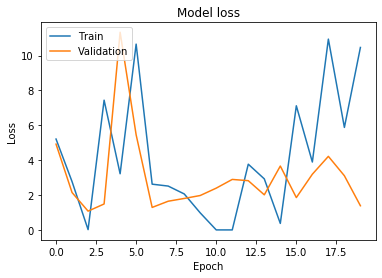

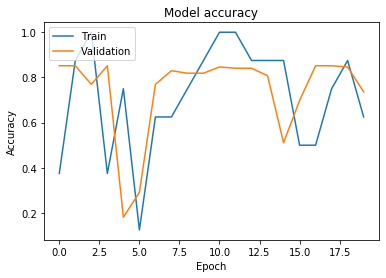

6/6 [==============================] - 0s 997us/step


In [212]:
verbose, epoch, batch_size = 1, 100, 4
activationFunction='relu'

def VGGNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = VGGNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

vgg_acc_n = accuracy_score(y_pred, y_test)
vgg_roc_n = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
vgg_prec_n = precision_score(y_pred, y_test)
vgg_rec_n = recall_score(y_pred, y_test)
vgg_f1_n = f1_score(y_pred, y_test)
vgg_mcc_n = matthews_corrcoef(y_pred, y_test)
vgg_kap_n = cohen_kappa_score(y_pred, y_test)
vgg_jacc_n = jaccard_score(y_pred, y_test)
vgg_gmea_n = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-CLN-WSI - VGGNets',vgg_acc_n,vgg_roc_n,vgg_prec_n,vgg_rec_n,vgg_f1_n,vgg_mcc_n,vgg_kap_n,vgg_jacc_n,vgg_gmea_n)

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 1009, 128)         384       
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 504, 128)          0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 504, 128)          0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 64512)             0         
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 129026    
Total params: 129,410
Trainable params: 129,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 152ms/step - loss: 0.7113 - accuracy: 0.6250 - val_loss: 14.

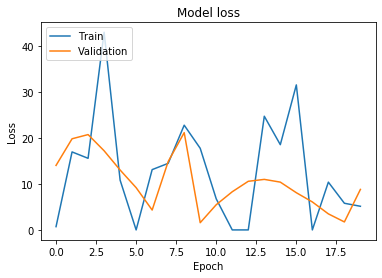

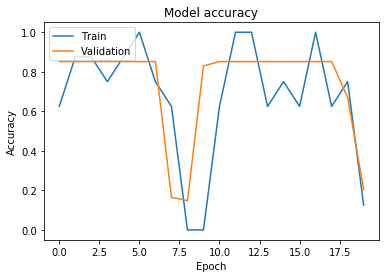

6/6 [==============================] - 0s 1ms/step


In [213]:
def ResNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = ResNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

res_acc_n = accuracy_score(y_pred, y_test)
res_roc_n = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
res_prec_n = precision_score(y_pred, y_test)
res_rec_n = recall_score(y_pred, y_test)
res_f1_n = f1_score(y_pred, y_test)
res_mcc_n = matthews_corrcoef(y_pred, y_test)
res_kap_n = cohen_kappa_score(y_pred, y_test)
res_jacc_n = jaccard_score(y_pred, y_test)
res_gmea_n = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-CLN-WSI - ResNets',res_acc_n,res_roc_n,res_prec_n,res_rec_n,res_f1_n,res_mcc_n,res_kap_n,res_jacc_n,res_gmea_n)

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_41 (Conv1D)           (None, 1009, 128)         384       
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 504, 128)          0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 504, 128)          0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 64512)             0         
_________________________________________________________________
dense_41 (Dense)             (None, 2)                 129026    
Total params: 129,410
Trainable params: 129,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 156ms/step - loss: 17.7883 - accuracy: 0.1250 - val_loss: 1.

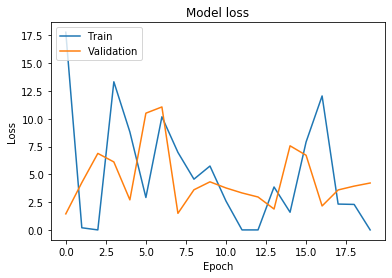

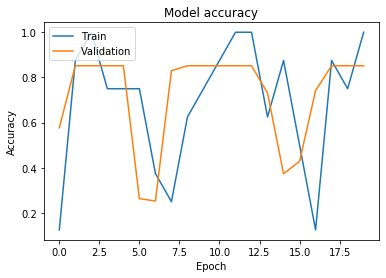

6/6 [==============================] - 0s 997us/step


In [214]:
def DenseNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = DenseNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

dense_acc_n = accuracy_score(y_pred, y_test)
dense_roc_n = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
dense_prec_n = precision_score(y_pred, y_test)
dense_rec_n = recall_score(y_pred, y_test)
dense_f1_n = f1_score(y_pred, y_test)
dense_mcc_n = matthews_corrcoef(y_pred, y_test)
dense_kap_n = cohen_kappa_score(y_pred, y_test)
dense_jacc_n = jaccard_score(y_pred, y_test)
dense_gmea_n = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CNV-CLN-WSI - DenseNets',dense_acc_n,dense_roc_n,dense_prec_n,dense_rec_n,dense_f1_n,dense_mcc_n,dense_kap_n,dense_jacc_n,dense_gmea_n)

# CLN-WSI-EXP-CNV

In [215]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(multimodal, y_multimodal, test_size = 0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((907, 1410), (907,), (161, 1410), (161,))

In [216]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm_acc_o = accuracy_score(y_pred, y_test)
svm_roc_o = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm_prec_o = precision_score(y_pred, y_test)
svm_rec_o = recall_score(y_pred, y_test)
svm_f1_o = f1_score(y_pred, y_test)
svm_mcc_o = matthews_corrcoef(y_pred, y_test)
svm_kap_o = cohen_kappa_score(y_pred, y_test)
svm_jacc_o = jaccard_score(y_pred, y_test)
svm_gmea_o = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI-EXP-CNV - SVM - rbf',svm_acc_o,svm_roc_o,svm_prec_o,svm_rec_o,svm_f1_o,svm_mcc_o,svm_kap_o,svm_jacc_o,svm_gmea_o)

In [217]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

svm1_acc_o = accuracy_score(y_pred, y_test)
svm1_roc_o = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm1_prec_o = precision_score(y_pred, y_test)
svm1_rec_o = recall_score(y_pred, y_test)
svm1_f1_o = f1_score(y_pred, y_test)
svm1_mcc_o = matthews_corrcoef(y_pred, y_test)
svm1_kap_o = cohen_kappa_score(y_pred, y_test)
svm1_jacc_o = jaccard_score(y_pred, y_test)
svm1_gmea_o = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI-EXP-CNV - SVM - Poly',svm1_acc_o,svm1_roc_o,svm1_prec_o,svm1_rec_o,svm1_f1_o,svm1_mcc_o,svm1_kap_o,svm1_jacc_o,svm1_gmea_o)

In [218]:
clf = SVC(C=c,kernel=utility_kernel, probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm2_acc_o = accuracy_score(y_pred, y_test)
svm2_roc_o = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm2_prec_o = precision_score(y_pred, y_test)
svm2_rec_o = recall_score(y_pred, y_test)
svm2_f1_o = f1_score(y_pred, y_test)
svm2_mcc_o = matthews_corrcoef(y_pred, y_test)
svm2_kap_o = cohen_kappa_score(y_pred, y_test)
svm2_jacc_o = jaccard_score(y_pred, y_test)
svm2_gmea_o = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI-EXP-CNV - SVM - Utility ',svm2_acc_o,svm2_roc_o,svm2_prec_o,svm2_rec_o,svm2_f1_o,svm2_mcc_o,svm2_kap_o,svm2_jacc_o,svm2_gmea_o)

In [219]:
clf = SVC(kernel ='linear', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm3_acc_o = accuracy_score(y_pred, y_test)
svm3_roc_o = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm3_prec_o = precision_score(y_pred, y_test)
svm3_rec_o = recall_score(y_pred, y_test)
svm3_f1_o = f1_score(y_pred, y_test)
svm3_mcc_o = matthews_corrcoef(y_pred, y_test)
svm3_kap_o = cohen_kappa_score(y_pred, y_test)
svm3_jacc_o = jaccard_score(y_pred, y_test)
svm3_gmea_o = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI-EXP-CNV - SVM - Linear ',svm3_acc_o,svm3_roc_o,svm3_prec_o,svm3_rec_o,svm3_f1_o,svm3_mcc_o,svm3_kap_o,svm3_jacc_o,svm3_gmea_o)

In [220]:
clf = SVC(kernel ='sigmoid', probability=True)

# fit the model 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

svm4_acc_o = accuracy_score(y_pred, y_test)
svm4_roc_o = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
svm4_prec_o = precision_score(y_pred, y_test)
svm4_rec_o = recall_score(y_pred, y_test)
svm4_f1_o = f1_score(y_pred, y_test)
svm4_mcc_o = matthews_corrcoef(y_pred, y_test)
svm4_kap_o = cohen_kappa_score(y_pred, y_test)
svm4_jacc_o = jaccard_score(y_pred, y_test)
svm4_gmea_o = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI-EXP-CNV - SVM - Sigmoid',svm4_acc_o,svm4_roc_o,svm4_prec_o,svm4_rec_o,svm4_f1_o,svm4_mcc_o,svm4_kap_o,svm4_jacc_o,svm4_gmea_o)

In [221]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model 
rf = RandomForestClassifier(n_estimators=100, random_state=0)


# fit the model 
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

rf_acc_o = accuracy_score(y_pred, y_test)
rf_roc_o = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
rf_prec_o = precision_score(y_pred, y_test)
rf_rec_o = recall_score(y_pred, y_test)
rf_f1_o = f1_score(y_pred, y_test)
rf_mcc_o = matthews_corrcoef(y_pred, y_test)
rf_kap_o = cohen_kappa_score(y_pred, y_test)
rf_jacc_o = jaccard_score(y_pred, y_test)
rf_gmea_o = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI-EXP-CNV - RF',rf_acc_o,rf_roc_o,rf_prec_o,rf_rec_o,rf_f1_o,rf_mcc_o,rf_kap_o,rf_jacc_o,rf_gmea_o)

In [222]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)

dt_acc_o = accuracy_score(y_pred, y_test)
dt_roc_o = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
dt_prec_o = precision_score(y_pred, y_test)
dt_rec_o = recall_score(y_pred, y_test)
dt_f1_o = f1_score(y_pred, y_test)
dt_mcc_o = matthews_corrcoef(y_pred, y_test)
dt_kap_o = cohen_kappa_score(y_pred, y_test)
dt_jacc_o = jaccard_score(y_pred, y_test)
dt_gmea_o = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI-EXP-CNV - DT',dt_acc_o,dt_roc_o,dt_prec_o,dt_rec_o,dt_f1_o,dt_mcc_o,dt_kap_o,dt_jacc_o,dt_gmea_o)

In [223]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.pipeline import Pipeline

# instantiate the model
nb=  GaussianNB()

# fit the model 
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
y_prob = nb.predict_proba(X_test)

nb_acc_o = accuracy_score(y_pred, y_test)
nb_roc_o = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
nb_prec_o = precision_score(y_pred, y_test)
nb_rec_o = recall_score(y_pred, y_test)
nb_f1_o = f1_score(y_pred, y_test)
nb_mcc_o = matthews_corrcoef(y_pred, y_test)
nb_kap_o = cohen_kappa_score(y_pred, y_test)
nb_jacc_o = jaccard_score(y_pred, y_test)
nb_gmea_o = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI-EXP-CNV - NB',nb_acc_o,nb_roc_o,nb_prec_o,nb_rec_o,nb_f1_o,nb_mcc_o,nb_kap_o,nb_jacc_o,nb_gmea_o)

In [224]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2 = SVC(probability=True)
clf3 = DecisionTreeClassifier(max_depth=30)

eclf1 = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train, y_train)

y_pred = eclf1.predict(X_test)
y_prob = eclf1.predict_proba(X_test)

vot_acc_o = accuracy_score(y_pred, y_test)
vot_roc_o = roc_auc_score(y_test, eclf1.predict_proba(X_test)[:, 1])
vot_prec_o = precision_score(y_pred, y_test)
vot_rec_o = recall_score(y_pred, y_test)
vot_f1_o = f1_score(y_pred, y_test)
vot_mcc_o = matthews_corrcoef(y_pred, y_test)
vot_kap_o = cohen_kappa_score(y_pred, y_test)
vot_jacc_o = jaccard_score(y_pred, y_test)
vot_gmea_o = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI-EXP-CNV- vot',vot_acc_o,vot_roc_o,vot_prec_o,vot_rec_o,vot_f1_o,vot_mcc_o,vot_kap_o,vot_jacc_o,vot_gmea_o)

In [225]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

X_train=X_train
X_test=X_test

X_train = X_train.reshape(-1, X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 1409, 128)         384       
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 704, 128)          0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 704, 128)          0         
_________________________________________________________________
flatten_42 (Flatten)         (None, 90112)             0         
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 180226    
Total params: 180,610
Trainable params: 180,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 1s 290ms/step - loss: 10.1488 - accuracy: 0.8750 - val_loss: 10

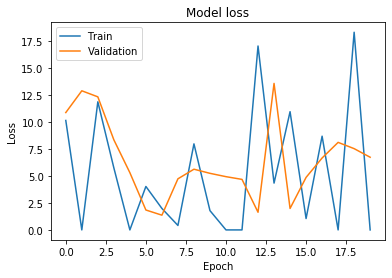

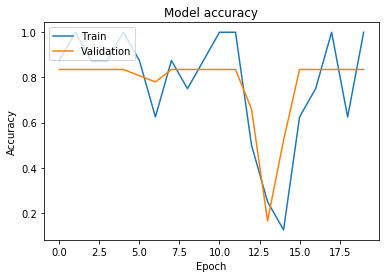

6/6 [==============================] - 0s 2ms/step


In [226]:
verbose, epoch, batch_size = 1, 100, 4
activationFunction='relu'

def VGGNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = VGGNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

#y_prob = cnnmodel.predict_proba(X_test)[:, 1]

vgg_acc_o = accuracy_score(y_pred, y_test)
vgg_roc_o = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
vgg_prec_o = precision_score(y_pred, y_test)
vgg_rec_o = recall_score(y_pred, y_test)
vgg_f1_o = f1_score(y_pred, y_test)
vgg_mcc_o = matthews_corrcoef(y_pred, y_test)
vgg_kap_o = cohen_kappa_score(y_pred, y_test)
vgg_jacc_o = jaccard_score(y_pred, y_test)
vgg_gmea_o = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI-EXP-CNV - VGGNets',vgg_acc_o,vgg_roc_o,vgg_prec_o,vgg_rec_o,vgg_f1_o,vgg_mcc_o,vgg_kap_o,vgg_jacc_o,vgg_gmea_o)

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_43 (Conv1D)           (None, 1409, 128)         384       
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 704, 128)          0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 704, 128)          0         
_________________________________________________________________
flatten_43 (Flatten)         (None, 90112)             0         
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 180226    
Total params: 180,610
Trainable params: 180,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 162ms/step - loss: 1.1423 - accuracy: 0.5000 - val_loss: 15.

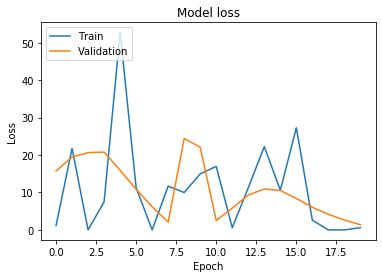

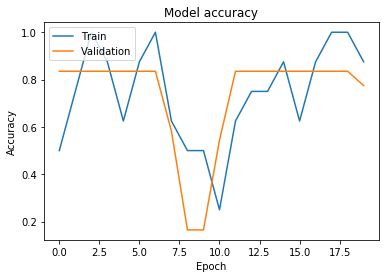

6/6 [==============================] - 0s 997us/step


In [227]:
def ResNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = ResNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

res_acc_o = accuracy_score(y_pred, y_test)
res_roc_o = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
res_prec_o = precision_score(y_pred, y_test)
res_rec_o = recall_score(y_pred, y_test)
res_f1_o = f1_score(y_pred, y_test)
res_mcc_o = matthews_corrcoef(y_pred, y_test)
res_kap_o = cohen_kappa_score(y_pred, y_test)
res_jacc_o = jaccard_score(y_pred, y_test)
res_gmea_o = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI-EXP-CNV - ResNets',res_acc_o,res_roc_o,res_prec_o,res_rec_o,res_f1_o,res_mcc_o,res_kap_o,res_jacc_o,res_gmea_o)

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 1409, 128)         384       
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 704, 128)          0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 704, 128)          0         
_________________________________________________________________
flatten_44 (Flatten)         (None, 90112)             0         
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 180226    
Total params: 180,610
Trainable params: 180,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 0s 152ms/step - loss: 0.3372 - accuracy: 0.7500 - val_loss: 7.3

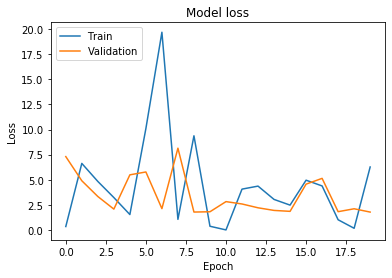

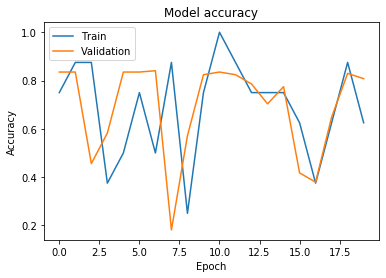

6/6 [==============================] - 0s 997us/step


In [228]:
def DenseNets():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(MaxPooling1D(pool_size=2))
    cnnmodel.add(Dropout(rate=0.2))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(2, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = DenseNets()

modelhistory= cnnmodel.fit(X_train, Y_train, epochs=20,steps_per_epoch=2, verbose=verbose, validation_split=0.2, batch_size = batch_size)

# Plot training & validation loss values
plt.plot(modelhistory.history['loss'])
plt.plot(modelhistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png', format='png', dpi=1200)
plt.show()


# Plot training & validation accuracy values
plt.plot(modelhistory.history['accuracy'])
plt.plot(modelhistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png', format='png', dpi=1200)
plt.show()

cnnpredictions = cnnmodel.predict(X_test, verbose=1)
cnn_predict=np.argmax(cnnpredictions,axis=1)

y_pred = cnnmodel.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred,axis=1)

y_prob = cnnmodel.predict_proba(X_test)[:, 1]

dense_acc_o = accuracy_score(y_pred, y_test)
dense_roc_o = roc_auc_score(y_test, cnnmodel.predict_proba(X_test)[:, 1])
dense_prec_o = precision_score(y_pred, y_test)
dense_rec_o = recall_score(y_pred, y_test)
dense_f1_o = f1_score(y_pred, y_test)
dense_mcc_o = matthews_corrcoef(y_pred, y_test)
dense_kap_o = cohen_kappa_score(y_pred, y_test)
dense_jacc_o = jaccard_score(y_pred, y_test)
dense_gmea_o = fbeta_score(y_pred, y_test, beta=0.5)

storeResults('CLN-WSI-EXP-CNV - DenseNets',dense_acc_o,dense_roc_o,dense_prec_o,dense_rec_o,dense_f1_o,dense_mcc_o,dense_kap_o,dense_jacc_o,dense_gmea_o)

# Comparison

In [229]:
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                        'ROC score' : roc,
                        'Precision': precision,
                        'Recall'   : recall,
                        'F1-Score': f1score,
                        'MCC' : mcc,
                        'Kappa Score' : kappa,
                       'Jaccard Score' : jacc,
                       'G-Measure' : gmea
                      })

In [230]:
result

,ML Model,Accuracy,ROC score,Precision,Recall,F1-Score,MCC,Kappa Score,Jaccard Score,G-Measure
0,CLN - SVM - rbf,0.839,0.768,1.000,0.839,0.912,0.000,0.000,0.839,0.963
1,CLN - SVM - Poly,0.826,0.774,0.985,0.836,0.905,-0.049,-0.024,0.826,0.951
2,CLN - SVM - Utility,0.783,0.628,0.889,0.857,0.873,0.131,0.130,0.774,0.882
3,CLN - SVM - Linear,0.839,0.557,1.000,0.839,0.912,0.000,0.000,0.839,0.963
4,CLN - SVM - Sigmoid,0.758,0.473,0.889,0.833,0.860,-0.041,-0.040,0.755,0.877
...,...,...,...,...,...,...,...,...,...,...
175,CLN-WSI-EXP-CNV - NB,0.696,0.692,0.723,0.900,0.802,0.202,0.181,0.669,0.752
176,CLN-WSI-EXP-CNV- vot,0.826,0.534,0.964,0.852,0.904,0.010,0.007,0.825,0.939
177,CLN-WSI-EXP-CNV - VGGNets,0.851,0.513,1.000,0.851,0.919,0.000,0.000,0.851,0.966
178,CLN-WSI-EXP-CNV - ResNets,0.814,0.550,0.956,0.845,0.897,-0.082,-0.063,0.814,0.932


In [231]:
print(result.to_string())

                             ML Model  Accuracy  ROC score  Precision  Recall  F1-Score    MCC  Kappa Score  Jaccard Score  G-Measure
0                     CLN - SVM - rbf     0.839      0.768      1.000   0.839     0.912  0.000        0.000          0.839      0.963
1                    CLN - SVM - Poly     0.826      0.774      0.985   0.836     0.905 -0.049       -0.024          0.826      0.951
2                CLN - SVM - Utility      0.783      0.628      0.889   0.857     0.873  0.131        0.130          0.774      0.882
3                 CLN - SVM - Linear      0.839      0.557      1.000   0.839     0.912  0.000        0.000          0.839      0.963
4                 CLN - SVM - Sigmoid     0.758      0.473      0.889   0.833     0.860 -0.041       -0.040          0.755      0.877
5                            CLN - RF     0.851      0.708      0.978   0.863     0.917  0.288        0.236          0.846      0.952
6                            CLN - DT     0.764      0.611    

In [232]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

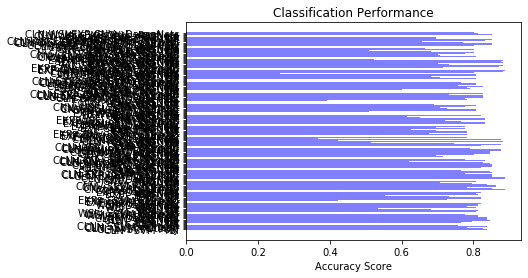

In [233]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()